 Tarea #1 - Ciencia de Redes (MII 2025-2)

- **Autor:** David Cáceres Ovalle
- **Profesor:** Wenceslao Palma
- **Fecha:** 11 de Octubre de 2025

---

## 1. Introducción

El presente informe detalla la implementación y análisis de redes complejas, abordando dos problemas fundamentales en la Ciencia de Redes. El primer problema se centra en la exploración del modelo Erdős-Rényi $G_{n,p}$, un modelo aleatorio clave para comprender la formación de enlaces y la emergencia de propiedades a nivel macroscópico. El segundo problema consiste en la caracterización de redes reales provenientes de diversos dominios, comparando sus estructuras con los modelos teóricos y evaluando sus propiedades intrínsecas, como la distribución de grado y las métricas de conectividad.


## 2. Problema 1: Experimentos con el modelo Erdős-Rényi $G_{n,p}$

El modelo Erdős-Rényi $G_{n,p}$ describe un grafo aleatorio donde se tienen $n$ nodos, y cada par de nodos posibles se conecta con una probabilidad $p$ independiente. Para este problema, se considerarán $n=100$ nodos y se explorarán 100 valores de $p$ en el rango $[0, 1]$.

Los ejemplos considerados son:
- $G_{100,0.001}$
- $G_{100,0.003}$
- $G_{100,0.005}$
- $G_{100,0.015}$
- $G_{100,0.05}$
- $G_{100,0.07}$
- $G_{100,0.09}$
- $G_{100,0.1}$



### Referencias
- Barabási, *Network Science*, Capítulos 1–2 (material proporcionado).
- Diapositivas de *Random Networks* (modelo $G(n,p)$, punto crítico, clustering).
- Rossi, R. A., & Ahmed, N. K. (2015). The Network Data Repository with Interactive Graph Analytics and Visualization. AAAI. https://networkrepository.com

In [ ]:
# @title
!pip  -q install networkx==3.2.1
!pip  -q install powerlaw
!pip  -q install matplotlib
!pip  -q install pandas
!pip  -q install scipy
!pip  -q install requests
!pip  -q install tqdm
print ( "Instalación de bibliotecas realizada!!!")
# Imports
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import math
import textwrap
import re, textwrap
import urllib.request, urllib.parse, zipfile, gzip, shutil, os

from matplotlib.ticker import MaxNLocator
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pathlib import Path
from IPython.display import Javascript, display, Markdown

%matplotlib inline



Instalación de bibliotecas realizada!!!


In [ ]:
# @title
# Parámetros de la simulación
seed_base = 12021974  # Semilla base para la reproducibilidad de los grafos generados
ejemplos = [(0.010,100),  (0.030,100),(0.050,100),(0.15,100),(0.5,100),(0.7,100),(0.9,100),(1,100)]  # (p,n)

In [ ]:
# @title
# ==== Metodos utilitarios ====
try:
    from google.colab import output
    from IPython.display import HTML, display
    def _get_output_width():
        display(HTML('<div id="probe-width" style="width:100%;height:0;"></div>'))
        return int(output.eval_js('document.getElementById("probe-width").getBoundingClientRect().width'))
    out_w = _get_output_width()
except Exception:
    out_w = 1280
# --- Mapeo de claves a etiquetas legibles ---
MAPA = {
    "1_nro_conexas": "# Conexas",
    "2_lcc_mayor_tamano": "|LCC|",
    "3_avg_minimo_path_lcc_mayor_tamano": "⟨l⟩_LCC",
    "4_densidad": "ρ (densidad)",
    "5_clustering": "⟨C⟩ (clustering)",
    "6_avg_degree": "⟨k⟩",
    "7_num_links": "L",
    "8_num_nodos": "N",
    "p": "p",
}

def _pretty_key(k):
    k = str(k)
    return MAPA.get(k, k.replace("_", " "))

def _smart(v):
    if isinstance(v, float):
        s = f"{v:.4f}"
        return s.rstrip("0").rstrip(".")
    return v

import re, pandas as pd

def _to_rows(data):
    if isinstance(data, dict):
        def _order(k):
            m = re.match(r"^(\d+)_", str(k))
            return (int(m.group(1)) if m else 999, str(k))
        items = sorted(data.items(), key=lambda kv: _order(kv[0]))
        return [[_pretty_key(k), _smart(v)] for k, v in items]

    if isinstance(data, pd.DataFrame):
        return [[_smart(x) for x in row] for row in data.values.tolist()]

    if isinstance(data, (list, tuple)):
        if not data:
            return []
        if isinstance(data[0], (list, tuple)) and len(data[0]) == 2:
            return [[_pretty_key(a), _smart(b)] for a, b in data]
        if isinstance(data[0], (list, tuple)):
            rows = []
            for row in data:
                if len(row) >= 1:
                    first = _pretty_key(row[0])
                    rest  = [_smart(x) for x in row[1:]]
                    rows.append([first] + rest)
                else:
                    rows.append([_smart(row)])
            return rows
        return [[_smart(x)] for x in data]

    return [[_smart(data)]]

def dibujar_tabla(ax_t, data, fontsize=8, width_frac=0.95):
    ax_t.axis("off")
    rows = _to_rows(data)
    if not rows:
        return None

    width_frac = min(max(width_frac, 0.0), 1.0)
    left = (1.0 - width_frac) / 2.0
    bbox = [left, 0.0, width_frac, 1.0]

    ncols = len(rows[0]) if hasattr(rows[0], '__len__') else 1
    if ncols == 2:
        colWidths = [0.7 * width_frac, 0.3 * width_frac]
    else:
        colWidths = [width_frac / ncols] * ncols

    tbl = ax_t.table(cellText=rows, bbox=bbox, cellLoc="left",
                     colWidths=colWidths)

    tbl.auto_set_font_size(False)
    tbl.set_fontsize(fontsize)
    tbl.scale(1.0, 1.08)

    for r in range(len(rows)):
        color = "#FBFBFB" if r % 2 == 1 else "white"
        for c in range(ncols):
            tbl[(r, c)].set_facecolor(color)

    if ncols == 2:
        for r in range(len(rows)):
            tbl[(r, 1)].get_text().set_ha("right")

    return tbl

#------- Descarga de dataset desde url



def preparar_grafo_desde_url(url: str, extensiones_preferidas=(".mtx", ".txt", ".gml")) -> Path:
    """
    Descarga 'url' (ZIP o GZ), descomprime y retorna la ruta local del archivo de grafo.
    - Prioriza archivos con extensiones en 'extensiones_preferidas' dentro del ZIP.
    - Si es .gz, lo descomprime al mismo nombre sin .gz.
    - Si ya existe un archivo de salida con contenido (>0 bytes), no vuelve a hacerlo.
    Retorna: Path al archivo final.
    """
    # --- utilidades internas ---
    def _descargar(origen: str, destino: Path):
        destino.parent.mkdir(parents=True, exist_ok=True)
        print(f"↓ Descargando {origen} → {destino}")
        urllib.request.urlretrieve(origen, destino.as_posix())

    def _descomprimir_gz(src_gz: Path, out_path: Path):
        print(f"↪ Descomprimiendo (gz) {src_gz} → {out_path}")
        with gzip.open(src_gz, "rb") as f_in, open(out_path, "wb") as f_out:
            shutil.copyfileobj(f_in, f_out)

    def _elegir_miembro_zip(zf: zipfile.ZipFile):
        nombres = zf.namelist()
        # Limpia nombres (evita directorios)
        candidatos = [n for n in nombres if not n.endswith("/")]
        # Ordena dando prioridad a las extensiones preferidas
        def score(n):
            nlow = n.lower()
            for i, ext in enumerate(extensiones_preferidas):
                if nlow.endswith(ext):
                    return i
            return 999
        candidatos.sort(key=score)
        if not candidatos:
            return None
        return candidatos[0]

    # --- preparar rutas temporales ---
    tmp_dir = Path(".tmp_grafos")
    tmp_dir.mkdir(exist_ok=True)
    nombre_url = Path(urllib.parse.urlparse(url).path).name  # e.g., 'ca-GrQc.zip' o 'file.mtx.gz'
    # Nombre temporal según extensión visible
    sufijo = Path(nombre_url).suffix.lower()
    tmp_file = tmp_dir / (nombre_url if nombre_url else "descarga.bin")
    if not tmp_file.suffix:
        tmp_file = tmp_dir / "descarga.bin"

    # Si ya tenemos un resultado previamente producido para esta URL, intenta reusar:
    # Heurística: si es .gz → salida sin .gz; si es .zip → no sabemos aún, se resolverá tras abrir el zip.
    posible_salida = None
    if sufijo == ".gz":
        base = nombre_url[:-3] if nombre_url.lower().endswith(".gz") else nombre_url + ".out"
        posible_salida = Path(base)

    # Descarga si no existe o si está vacío
    if not tmp_file.exists() or tmp_file.stat().st_size == 0:
        _descargar(url, tmp_file)

    # --- Detectar y descomprimir ---
    salida_final = None
    try:
        if zipfile.is_zipfile(tmp_file):
            print(f"• Detectado ZIP: {tmp_file}")
            with zipfile.ZipFile(tmp_file, "r") as zf:
                miembro = _elegir_miembro_zip(zf)
                if not miembro:
                    raise RuntimeError("El ZIP no contiene archivos útiles.")
                print(f"↪ Extrayendo miembro: {miembro}")
                # Extrae a tmp y luego mueve al cwd con solo el nombre base
                extraido = zf.extract(miembro, path=tmp_dir)
                extraido_path = Path(extraido)
                salida_final = Path(extraido_path.name)  # deja el archivo en el directorio actual
                # Si ya existe con contenido, no lo sobrescribas
                if not (salida_final.exists() and salida_final.stat().st_size > 0):
                    shutil.move(extraido_path.as_posix(), salida_final.as_posix())
        else:
            # Intento como GZ
            try:
                # Si no teníamos un nombre de salida, derívalo del .gz
                if posible_salida is None:
                    if tmp_file.name.lower().endswith(".gz"):
                        posible_salida = Path(tmp_file.name[:-3])
                    else:
                        posible_salida = Path(tmp_file.stem)  # 'descarga'
                salida_final = posible_salida
                if not (salida_final.exists() and salida_final.stat().st_size > 0):
                    _descomprimir_gz(tmp_file, salida_final)
            except OSError:
                # No es ZIP ni GZ válido
                raise RuntimeError(f"No pude descomprimir {tmp_file}: no es ZIP ni GZ válido.")
    finally:
        # Limpieza parcial (conserva el tmp_file por si quieres auditar)
        # Borra solo contenido extraído intermedio
        try:
            for p in tmp_dir.iterdir():
                # deja el archivo original descargado
                if p != tmp_file and p.is_file():
                    p.unlink()
                if p.is_dir():
                    shutil.rmtree(p, ignore_errors=True)
        except Exception:
            pass

    if not salida_final or not salida_final.exists() or salida_final.stat().st_size == 0:
        raise RuntimeError("No se obtuvo un archivo de salida válido.")

    print(f"✔ Listo: {salida_final} ({salida_final.stat().st_size} bytes)")
    return salida_final





### 2.1. Implementación del modelo $G_{n,p}$

La implementación del modelo Erdős-Rényi se realiza utilizando la función `nx.erdos_renyi_graph(n, p)` de la librería `networkx`, que genera un grafo no dirigido de manera eficiente y en el mismo metodo `modelo_metricas(n,p)` tambien se evaluan las metricas solicitadas.



In [ ]:
# @title
def modelo_metricas(n=None,p=None,G=None):
    """
    Genera grafico y Calcula métricas.

    Args:
        p (float): Probabilidad de conexión entre cada par de nodos.
        n (int): Cantidad de nodos de la red
    Returns:
        dict: Un diccionario con las métricas calculadas para el grafo.
              Incluye 'p', 'components', 'lcc_size', 'avg_shortest_path_lcc',
              'density' y 'clustering'.
    """
    if G is None:
      G = nx.erdos_renyi_graph(n, p, seed=seed_base)  # Implementacion de la red


    #   Analisis de la informacion de la red para metricas


    # Número de componentes conexas
    n_cc = nx.number_connected_components(G)

    # Cálculo del tamaño de la Componente Conexa Más Grande (LCC) y su camino mínimo promedio
    if G.number_of_nodes() == 0:
        # Manejo de caso para grafos sin nodos
        lcc_size = 0
        asp = float('nan') # No hay camino promedio si no hay nodos
    else:
        if G.number_of_edges() == 0:
            # Manejo de caso para grafos sin aristas
            lcc_size = 1 if n > 0 else 0 # Cada nodo es una componente de tamaño 1 si n>0
            asp = float('nan') # No hay caminos si no hay aristas
        else:
            # Encuentra los nodos de la componente conexa más grande
            lcc_nodes = max(nx.connected_components(G), key=len)
            # Calcula el tamaño de la LCC
            lcc_size = len(lcc_nodes)
            # Calcula el camino mínimo promedio solo si la LCC tiene más de un nodo
            if lcc_size > 1:
                # Crea un subgrafo con solo los nodos de la LCC
                H = G.subgraph(lcc_nodes).copy()
                # Calcula el camino mínimo promedio en el subgrafo de la LCC
                asp = nx.average_shortest_path_length(H)
            else:
                # Si la LCC tiene 0 o 1 nodo, no hay camino mínimo promedio significativo
                asp = float('nan')

    # Densidad del grafo (proporción de aristas existentes sobre las posibles)
    dens = nx.density(G)

    # Coeficiente de clustering promedio
    # Se calcula solo si hay más de un nodo para evitar errores
    clust = nx.average_clustering(G) if G.number_of_nodes() > 1 else 0.0

    # Retorna las métricas en un diccionario
    N = G.number_of_nodes()
    L = G.number_of_edges()
    avg_degree = 2 * L / N if N > 0 else float("nan")
    return G,{
        "p": p,
        "1_nro_conexas": n_cc,
        "2_lcc_mayor_tamano": lcc_size,
        "3_avg_minimo_path_lcc_mayor_tamano": asp,
        "4_densidad": dens,
        "5_clustering": clust,
        "6_avg_degree": avg_degree,
        "7_num_links": G.number_of_edges(),
        "8_num_nodos": G.number_of_nodes()
    }
# Generar Redes y calcula metricas
G_M = []



### 2.2. Dibujo de grafos para diferentes valores del parámetro $p$

Para ilustrar visualmente la transición en la estructura del grafo $G_{n,p}$ a medida que $p$ varía, se presentan a continuación ejemplos de grafos $G_{100,p}$ para valores bajos, intermedios y altos de $p$.




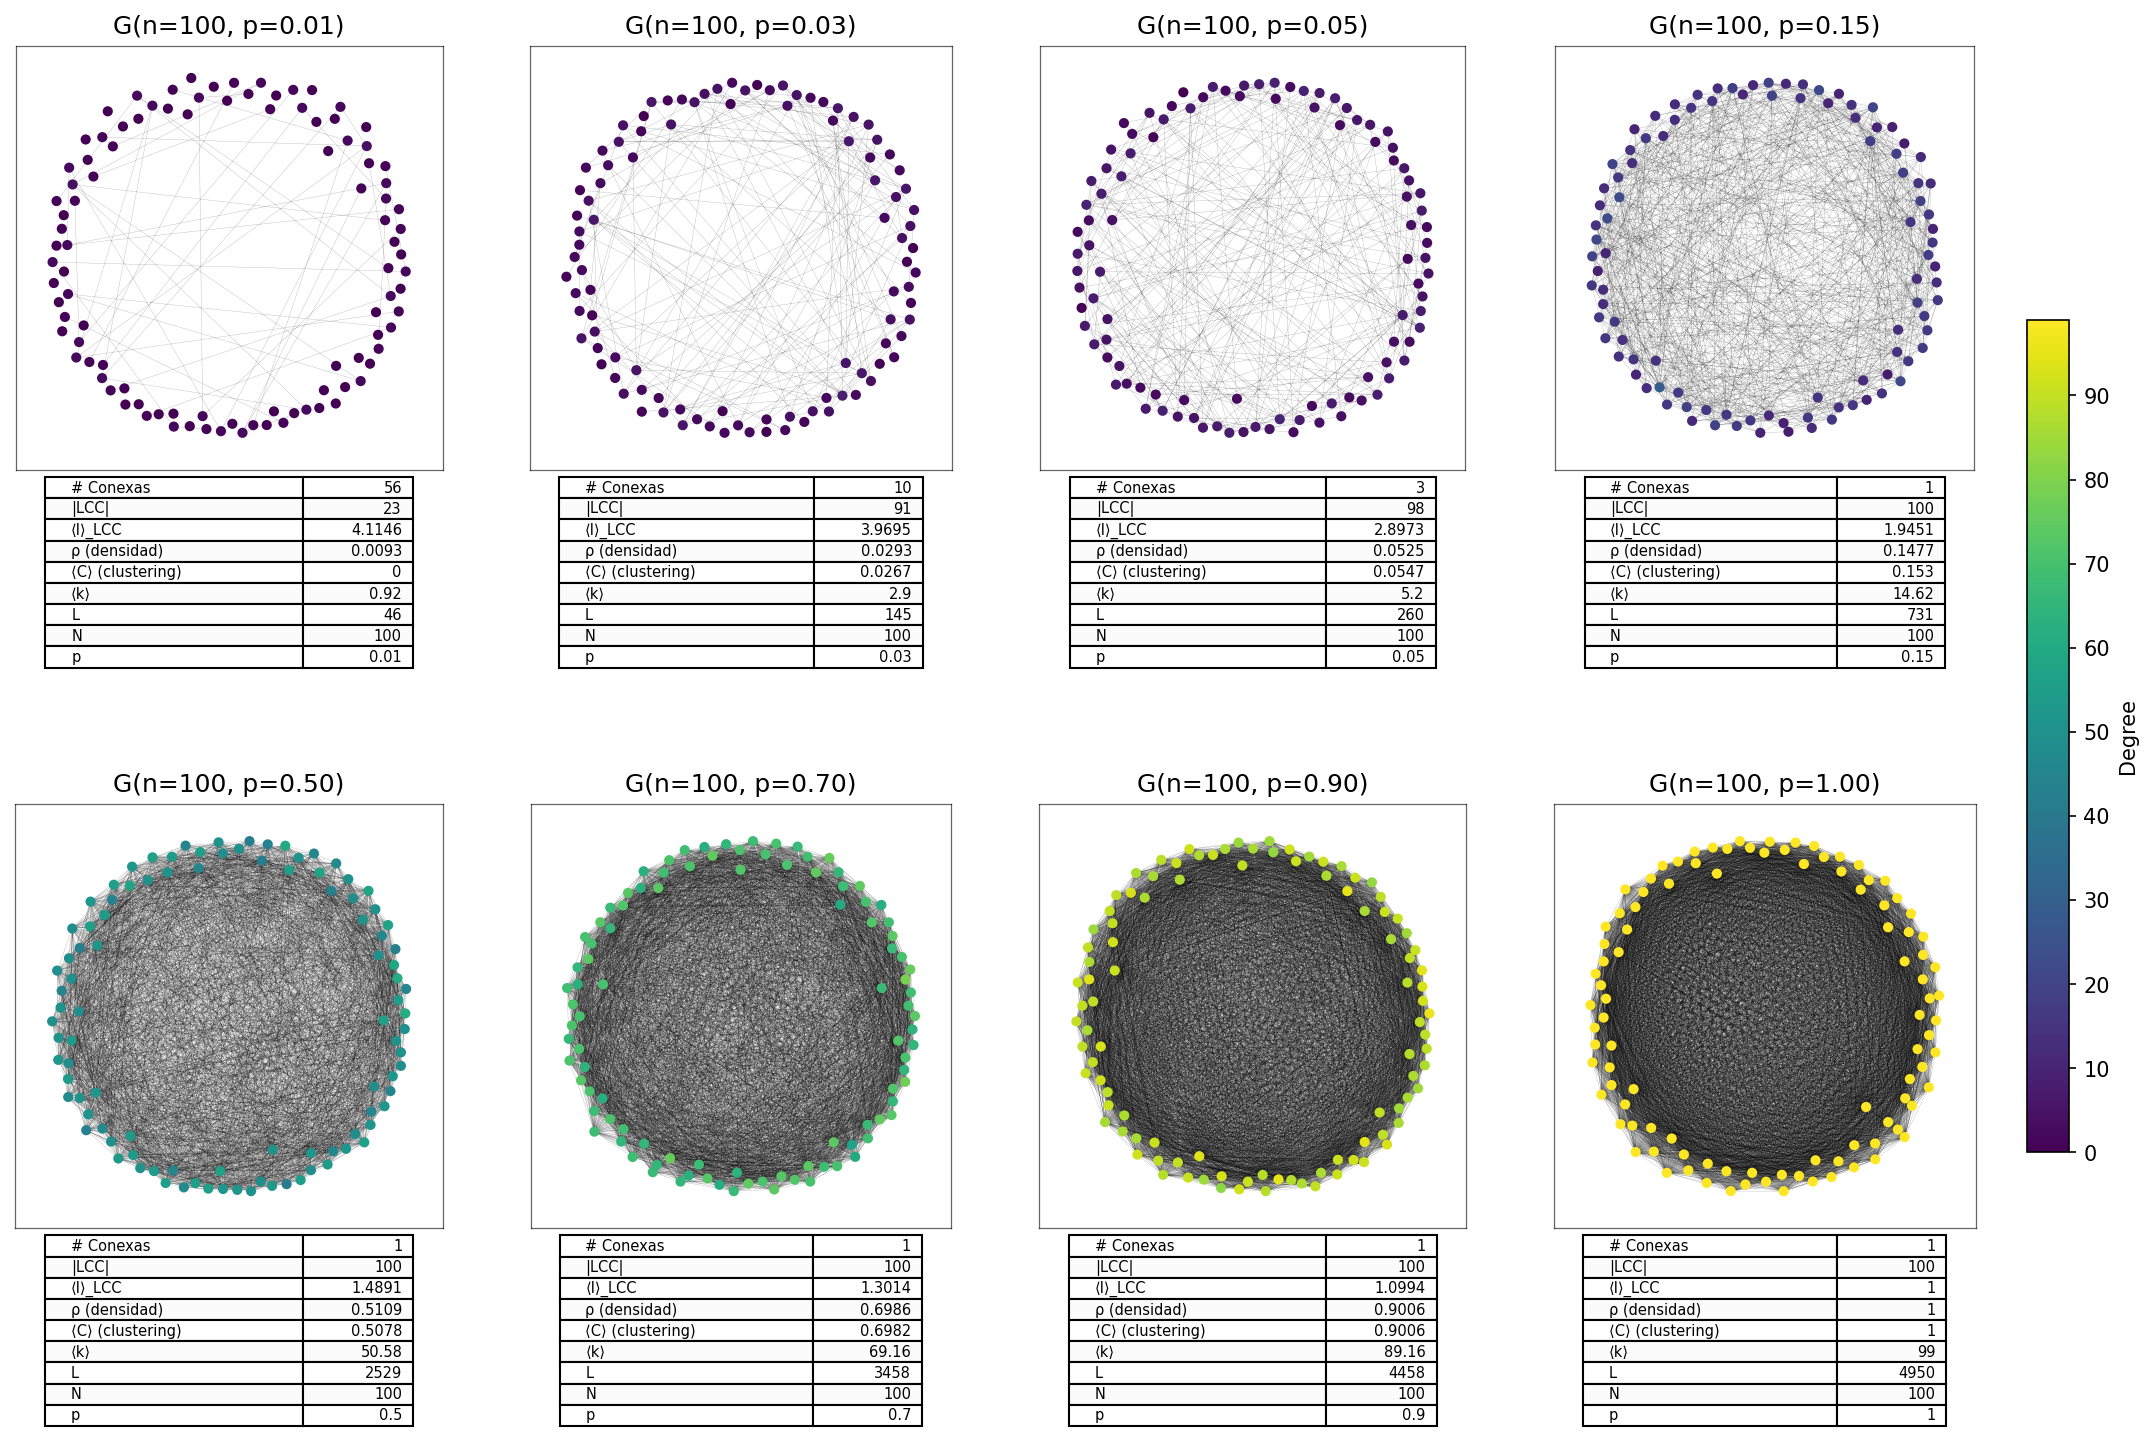

<IPython.core.display.Javascript object>

In [ ]:
# @title
#2.2. Dibujo de grafos para diferentes valores del parámetro p

def _dibuja(p, G, ax):
    nodelist = list(G.nodes())
    deg = dict(G.degree())
    vals = np.array([deg.get(n, 0) for n in nodelist], dtype=float)

    pos = nx.spring_layout(G, seed)
    nx.draw_networkx_edges(G, pos, ax=ax, width=0.15, alpha=0.35)
    nodes = nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=nodelist,
                                   node_size=15, node_color=vals,
                                   cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(f"G(n={G.number_of_nodes()}, p={p:.2f})", pad=6)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xticks([]); ax.set_yticks([])
    for s in ax.spines.values():
        s.set_linewidth(0.6); s.set_alpha(0.6)
    return nodes, "Degree"

# Calcular cual es el ancho de la pagina para desplegar graficos
dpi = 150
fig_w_in = 0.98 * out_w / dpi          # ~98% del ancho visible
cell_h_in =5                         # altura por celda (ajusta a gusto)
fig_h_in = cell_h_in * int(math.ceil(len(ejemplos) / 5.0))  # rows * altura
plt.close('all') # cierra cualquier grafico que quede abierto

cols = 4
rows = int(math.ceil(len(ejemplos) / cols))
fig = plt.figure(figsize=(fig_w_in, fig_h_in), dpi=dpi)
gs  = fig.add_gridspec(rows, cols)

axes_graph = [fig.add_subplot(gs[i//cols, i % cols]) for i in range(len(ejemplos))]

# posiciones comunes según mayor n
n_max = max(n for p, n in ejemplos)
seed = seed_base if 'seed_base' in globals() else 123
# genera grafos
for i,(p,n) in enumerate(ejemplos):
    #seed = seed_base + i
    G, m = modelo_metricas(n,p)
    G_M.append((G,m))

# rango global para la colorbar
degres = []
for i, (p, n) in enumerate(ejemplos):
    G = G_M[i][0]
    degres.extend(dict(G.degree()).values())
vmin, vmax = (min(degres), max(degres)) if degres else (0.0, 1.0)
norm = Normalize(vmin=vmin, vmax=vmax)
cmap = plt.colormaps['viridis']
sm   = plt.cm.ScalarMappable(norm=norm, cmap=cmap); sm.set_array([])


# Dibuja grafo y  tabla con datos
first_label = None
for i, (ax_g, (p, n)) in enumerate(zip(axes_graph, ejemplos)):
    G = G_M[i][0]
    nodos, etiqueta = _dibuja(p, G, ax_g)
    if first_label is None:
        first_label = etiqueta
    divider = make_axes_locatable(ax_g)
    ax_t = divider.append_axes("bottom", size="45%", pad=0.05)     # 0.05 separación gráfico-tabla, "40%" alto de la tabla respecto al eje del grafo
    rows_tbl = G_M[i][1]
    dibujar_tabla(ax_t, rows_tbl, fontsize=7, width_frac=0.86)    #  0.96 ancho relativo de la tabla (<=1)



# colorbar compartida
plt.subplots_adjust(left=0.02, right=0.90, top=0.97, bottom=0.05,
                    wspace=0.06, hspace=0.22)
cb = fig.colorbar(sm, ax=axes_graph, location='right', fraction=0.02, pad=0.01)
if first_label:
    cb.set_label(first_label)
from matplotlib.ticker import MaxNLocator
cb.ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()
display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 1e7})'))

### 2.3. Cálculo y Graficación de Métricas en función de $p$

Se calculo para cada grafo $G_{100,p}$ las siguientes métricas:
 - Número de componentes conexas
 - Tamaño de la componente conexa más grande
 - Camino mínimo promedio de la componente conexa más grande
 - Densidad del grafo
 - coeficiente de clustering promedio.

 Los resultados se presentan en una serie de gráficos a continuación.

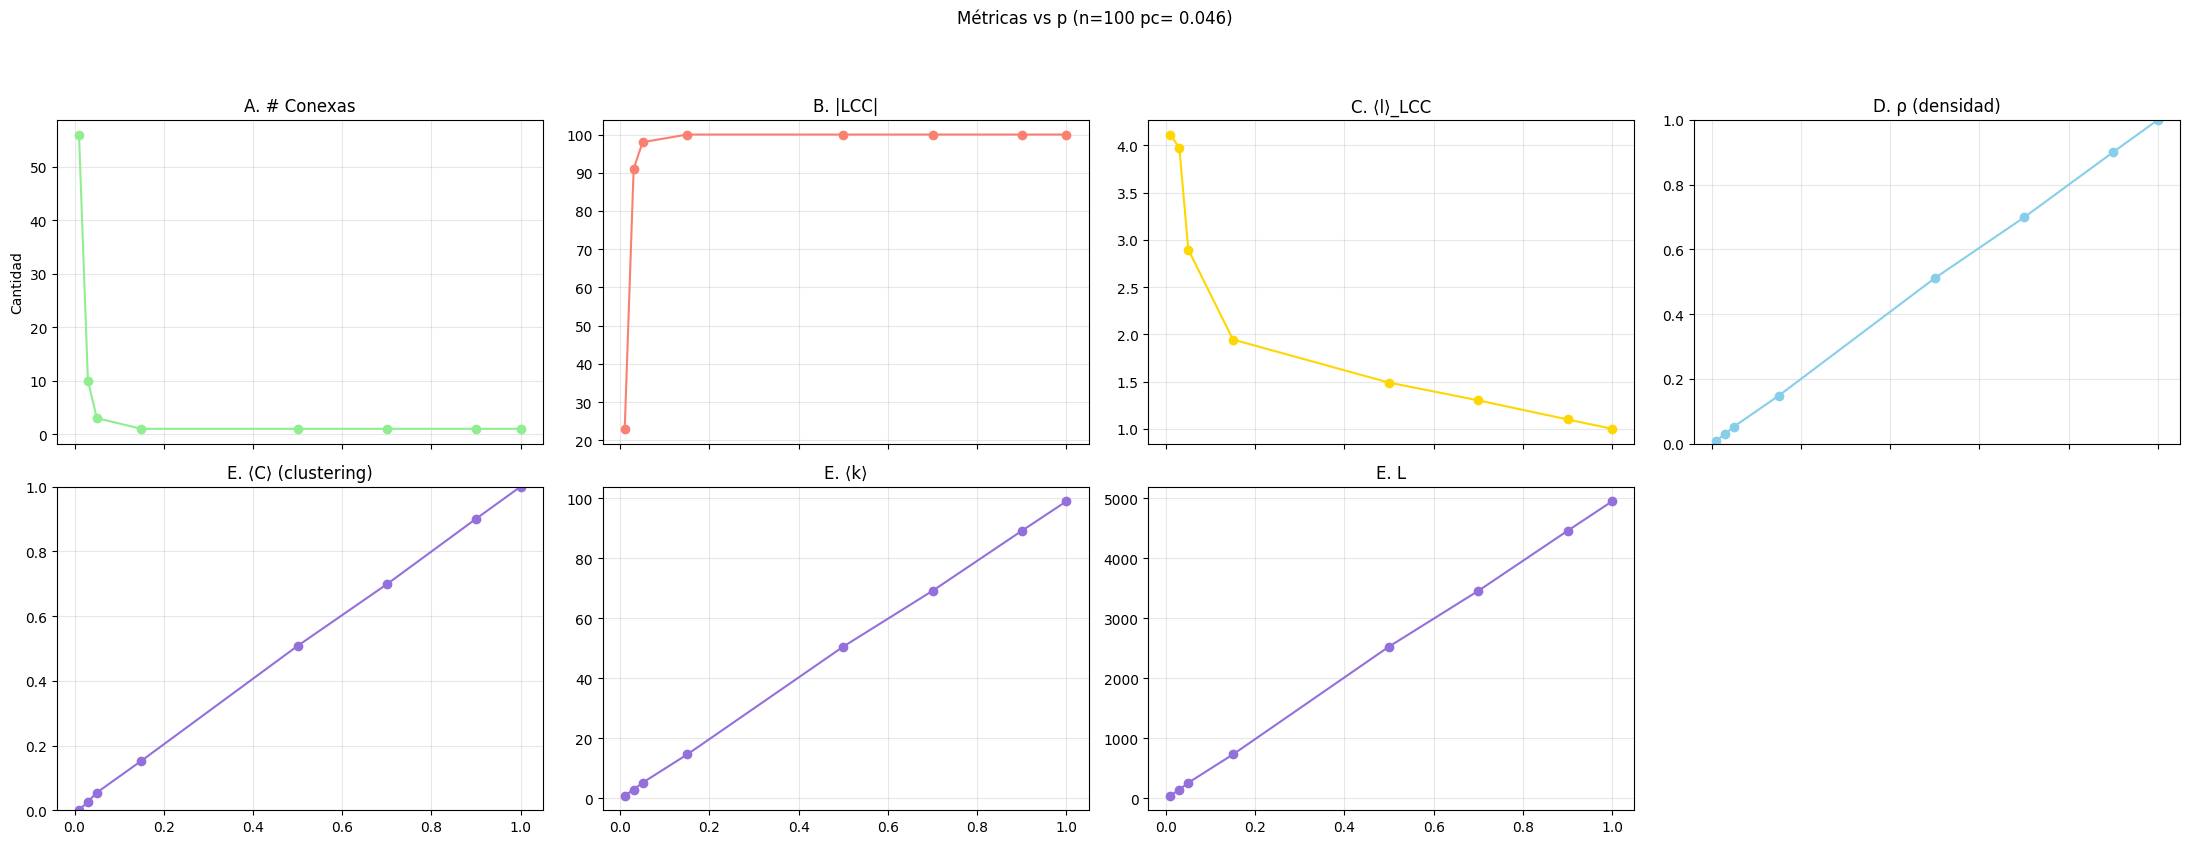

In [ ]:
# @title

ps, ns = [], []
m_conexas, m_lcc, m_asp, m_dens, m_clust, m_degree, m_links, m_nodos  = [], [], [], [], [], [], [], []


for i, (G, meta) in enumerate(G_M):
    p, n = ejemplos[i]
    ns.append(n)
    ps.append(meta["p"])
    m_conexas.append(meta["1_nro_conexas"])
    m_lcc.append(meta["2_lcc_mayor_tamano"])
    m_asp.append(meta["3_avg_minimo_path_lcc_mayor_tamano"])
    m_dens.append(meta["4_densidad"])
    m_clust.append(meta["5_clustering"])
    m_degree.append(meta["6_avg_degree"])
    m_links.append(meta["7_num_links"])
    m_nodos.append(meta["8_num_nodos"])

ord_idx = np.argsort(ps)
ps = np.array(ps)[ord_idx].tolist()
ns = np.array(ns)[ord_idx].tolist()
m_conexas = np.array(m_conexas)[ord_idx].tolist()
m_lcc = np.array(m_lcc)[ord_idx].tolist()
m_asp = np.array(m_asp, dtype=float)[ord_idx]
m_dens = np.array(m_dens)[ord_idx].tolist()
m_clust = np.array(m_clust)[ord_idx].tolist()

todos_iguales = all(x == ns[0] for x in ns)
titulo_n = ns[0] if todos_iguales else f"n∈{sorted(set(ns))}"
p_c = (math.log(titulo_n) / titulo_n) if isinstance(titulo_n, int) else None

fig, axes = plt.subplots(2, 4, figsize=(22, 8), sharex=True)

# 1) # Conexas
axes[0,0].plot(ps, m_conexas, marker='o', color='lightgreen')
axes[0,0].set_title("A. " + MAPA["1_nro_conexas"])
axes[0,0].set_ylabel("Cantidad")
axes[0,0].grid(True, alpha=0.3)

# 2) LCC (tamaño absoluto)
axes[0,1].plot(ps, m_lcc, marker='o', color='salmon')
axes[0,1].set_title("B. " + MAPA["2_lcc_mayor_tamano"])
axes[0,1].grid(True, alpha=0.3)

# 3) Distancia media en la LCC (oculta NaN)
mask = ~np.isnan(m_asp)
axes[0,2].plot(np.array(ps)[mask], m_asp[mask], marker='o', color='gold')
axes[0,2].set_title("C. " + MAPA["3_avg_minimo_path_lcc_mayor_tamano"])
axes[0,2].grid(True, alpha=0.3)

# 4) Densidad
axes[0,3].plot(ps, m_dens, marker='o', color='skyblue')
axes[0,3].set_title("D. " + MAPA["4_densidad"])
axes[0,3].set_ylim(0, 1)
axes[0,3].grid(True, alpha=0.3)

# 5) Clustering
axes[1,0].plot(ps, m_clust, marker='o', color='mediumpurple')
axes[1,0].set_title("E. " + MAPA["5_clustering"])
axes[1,0].set_ylim(0, 1)
axes[1,0].grid(True, alpha=0.3)

# 6) 6_avg_degree
axes[1,1].plot(ps, m_degree, marker='o', color='mediumpurple')
axes[1,1].set_title("E. " + MAPA["6_avg_degree"])
#axes[1,1].set_ylim(0, 1)
axes[1,1].grid(True, alpha=0.3)

# 6) 7_num_links
axes[1,2].plot(ps, m_links, marker='o', color='mediumpurple')
axes[1,2].set_title("E. " + MAPA["7_num_links"])
#axes[1,1].set_ylim(0, 1)
axes[1,2].grid(True, alpha=0.3)
axes[1, 3].remove()
for ax in axs:
    ax.set_xlabel("p")

if p_c is not None:
    for ax in axs:
        ax.axvline(p_c, linestyle='--', color='gray', alpha=0.85)
        y_top = ax.get_ylim()[1]
        ax.annotate("Pc", xy=(p_c, y_top),
                    xytext=(4, -4), textcoords="offset points",
                    va='top', ha='left', rotation=90, fontsize=9, color='gray')

fig.suptitle(f"Métricas vs p (n={titulo_n} pc= {p_c:.3f})", y=1.05, fontsize=12)

plt.tight_layout()
plt.show()


### 2.4. Conclusiones de los Experimentos con el Modelo Erdős-Rényi $G_{n,p}$

El análisis de las diversas métricas en función de la probabilidad $p$ revela una evolución característica y bien definida en la estructura de los grafos Erdős-Rényi, tal como se observa en los gráficos generados.

*   **Ejemplos de Grafos G(100, p) :** La visualización muestra claramente cómo el grafo transita de una colección de nodos aislados y pequeñas componentes a una red densamente conectada. Con $p=0.01$, predominan los nodos aislados; a $p=0.05$ empiezan a formarse algunas componentes; y para $p=0.15$ y $p=0.5$, la conectividad es sustancialmente mayor y en $p=0.90$ ya acercándose a un grafo completo.

*   **[Gráfico A] de Número de Componentes Conexas :** Se observa una disminución abrupta en el número de componentes conexas a medida que $p$ aumenta, concentrándose la mayoría de los nodos en una única componente gigante después de un valor crítico de $p$ (aproximadamente $p \approx 0.046$).

*   **[Gráfico B] LCC Tamaño de la Componente Conexa Más Grande :** Este gráfico complementa el anterior, mostrando un crecimiento exponencial en el tamaño de la componente más grande justo después del punto donde el número de componentes se reduce drásticamente, consolidando la mayoría de los nodos en una única estructura conectada.

*   **[Gráfico C] Camino Mínimo Promedio (Comp. Más Grande) ($\langle l \rangle$):** Para la componente gigante, el camino mínimo promedio disminuye rápidamente con el aumento de $p$, lo que evidencia el fenómeno de "mundo pequeño": a medida que la red se conecta más, la distancia promedio entre cualquier par de nodos se acorta notablemente.

*   **[Gráfico D] Degree ($\langle k \rangle$):** La densidad del grafo, que mide la proporción de aristas presentes respecto al máximo posible, muestra un incremento casi lineal con $p$. Esto es coherente con la naturaleza del modelo, donde cada incremento en $p$ aumenta directamente la probabilidad de formar nuevas aristas.

*   **[Gráfico E] Coeficiente de Clustering Promedio:** El coeficiente de clustering promedio también exhibe un aumento aproximadamente lineal con $p$. Esto indica que la tendencia de los vecinos de un nodo a ser vecinos entre sí es directamente proporcional a la probabilidad de conexión, reflejando el carácter aleatorio del modelo.

En resumen, los resultados gráficos demuestran la transición fundamental del modelo Erdős-Rényi, donde un ligero aumento en la probabilidad de conexión transforma una red dispersa en un sistema globalmente conectado con propiedades de "mundo pequeño", alta densidad y clustering proporcional a la probabilidad de aristas.

## 3. Problema 2: Experimentos con Redes Reales

Este problema se enfoca en el análisis de redes reales descargadas del Network Repository. Se seleccionaron tres redes de diferentes dominios (excluyendo el dominio "Generated Graphs") con un número de nodos entre 2500 y 5500.

### 2.a  Para cada red gr ́afique su distribuci ́on de grado y calcule (grafique) m ́etricas que las describan (< k >, < l >, σk, L, Densidad, etc.). Que observa? Son redes de libre escala? justifique.

#### 2.a.1. Selección y Justificación de Redes (G1, G2, G3)

Las siguientes redes fueron seleccionadas para proporcionar una diversidad de estructuras y dominios:
1.  **G1: Red de Citación de Artículos Científicos - Cora**

    *   **Dominio:** Ciencia / Red de Citación
    *   **Nodos:** 2708
    *   **Aristas:** 5278
    *   **Descripción:** La red Cora es un grafo de citas de artículos científicos en el campo del aprendizaje automático. Cada nodo representa un artículo de investigación y una arista dirigida indica que un artículo cita a otro. Los artículos se clasifican en una de siete categorías: sistemas basados en el conocimiento, aprendizaje genético, redes neuronales, aprendizaje probabilístico, aprendizaje por refuerzo, sistemas de reglas y teoría.
    *   **Justificación:** Esta red es un ejemplo clásico de interacciones académicas, similar a la coautoría. Representa cómo la investigación se construye sobre trabajos anteriores, formando un tejido de conocimiento interconectado. Al igual que en las redes de coautoría, se pueden observar nodos con alta centralidad (artículos seminales muy citados) y la formación de clusters que representan áreas de investigación específicas. Su tamaño es ideal para análisis sin requerir una gran capacidad de cómputo, y es un conjunto de datos muy utilizado para la evaluación de algoritmos de clasificación de nodos y análisis de comunidades.
    *   **Fuente:** [https://networkrepository.com/cora.php](https://networkrepository.com/cora.php)

2.  **G2: Red Eléctrica del Oeste de EE. UU.**
    *   **Dominio:** Infraestructura / Energía
    *   **Nodos:** 4941
    *   **Aristas:** 6594
    *   **Descripción:** Este es un modelo de la red eléctrica. En esta red
         cada nodo representa una entidad física como una central eléctrica (generador), una subestación o un transformador, Una arista representa una línea de transmisión de alta tensión que conecta dos de estos nodos.
    *   **Justificación:**  Es un conjunto de datos fundamental para estudiar la robustez y la vulnerabilidad de las infraestructuras a gran escala. Los investigadores la utilizan para simular fallos en cascada (apagones), analizar cómo se distribuye la carga eléctrica y modelar la eficiencia del sistema. Es un ejemplo perfecto de una red tecnológica cuya operatividad es crítica para la sociedad..
    *   **Fuente:** [https://nrvis.com/download/data/inf/inf-power.zip](https://nrvis.com/download/data/inf/inf-power.zip)

3.  **G3: Red de Colaboración de Erdős**
    *   **Dominio:** Ciencia / Colaboración
    *   **Nodos:** 5094
    *   **Aristas:** 7515
    *   **Descripción:** La red se centra en Paul Erdős, quien es famoso por haber colaborado con una cantidad inmensa de matemáticos. En esta red cada nodo es un autor (un científico). Una arista entre dos nodos significa que los dos autores han coescrito al menos un artículo científico. El nombre "Erdos992" se refiere específicamente a la red que incluye a los coautores de los coautores de Erdős. Es decir, personas con un Número de Erdős de 1 (colaboradores directos) y 2 (colaboradores de sus colaboradores)..
    *   **Justificación:** Es un conjunto de datos clásico para estudiar el fenómeno del "mundo pequeño". A pesar de su tamaño, la distancia promedio entre dos científicos cualquiera en la red es sorprendentemente corta. Se utiliza a menudo para analizar la estructura de las comunidades científicas, identificar a los investigadores más influyentes (centralidad) y estudiar cómo se difunde la información en las redes académicas.
    *   **Fuente:** [https://nrvis.com/download/data/ca/ca-Erdos992.zip](https://networkrepository.com/inf-power.php)


#### 2.a.2 Descarga de Datasets
Para realizar el análisis debemos descargar los dataset para G1, G2 y G3

In [ ]:
# @title
source = [
    ("G1","Ciencia / Red de Citación","Red de Citación de Artículos Científicos - Cora", "https://nrvis.com/download/data/labeled/cora.zip","cora.edges"),
    ("G2","Infraestructura / Energía","Red Eléctrica del Oeste de EE. UU.", "https://nrvis.com/download/data/inf/inf-power.zip","inf-power.mtx"),
    ("G3","Ciencia / Colaboración","Red de Colaboración de Erdős", "https://nrvis.com/download/data/ca/ca-Erdos992.zip","ca-Erdos992.mtx")
   ]

source_graph=[]

for id,dominio,nombre,url, archivo in source:
    ruta = preparar_grafo_desde_url(url)   # solo pasas la URL, hace todo
    source_graph.append((id,dominio,nombre,url,archivo))

↓ Descargando https://nrvis.com/download/data/labeled/cora.zip → .tmp_grafos/cora.zip
• Detectado ZIP: .tmp_grafos/cora.zip
↪ Extrayendo miembro: cora.edges
✔ Listo: cora.edges (59716 bytes)
↓ Descargando https://nrvis.com/download/data/inf/inf-power.zip → .tmp_grafos/inf-power.zip
• Detectado ZIP: .tmp_grafos/inf-power.zip
↪ Extrayendo miembro: inf-power.mtx
✔ Listo: inf-power.mtx (63106 bytes)
↓ Descargando https://nrvis.com/download/data/ca/ca-Erdos992.zip → .tmp_grafos/ca-Erdos992.zip
• Detectado ZIP: .tmp_grafos/ca-Erdos992.zip
↪ Extrayendo miembro: ca-Erdos992.mtx
✔ Listo: ca-Erdos992.mtx (64360 bytes)


#### 2.a.3 Análisis de Distribución de Grado y Métricas para Redes Individuales

Para cada una de las redes seleccionadas (G1, G2, G3), se cargó el grafo y se procedió a calcular y graficar su distribución de grado. Adicionalmente, se calculan las siguientes métricas:
* **Grado promedio ($\langle k \rangle$)**
* **Desviación estándar del grado ($\sigma_k$)**
* **LCC camino mínimo promedio ($\langle l \rangle$)**
* **Densidad**
* **Coeficiente de clustering promedio**

---

## Análisis  Red de Citación de Artículos Científicos - Cora

### Dominio: Ciencia / Red de Citación

### Archivo:cora.edges

### Nodos: 2708, Aristas: 5278

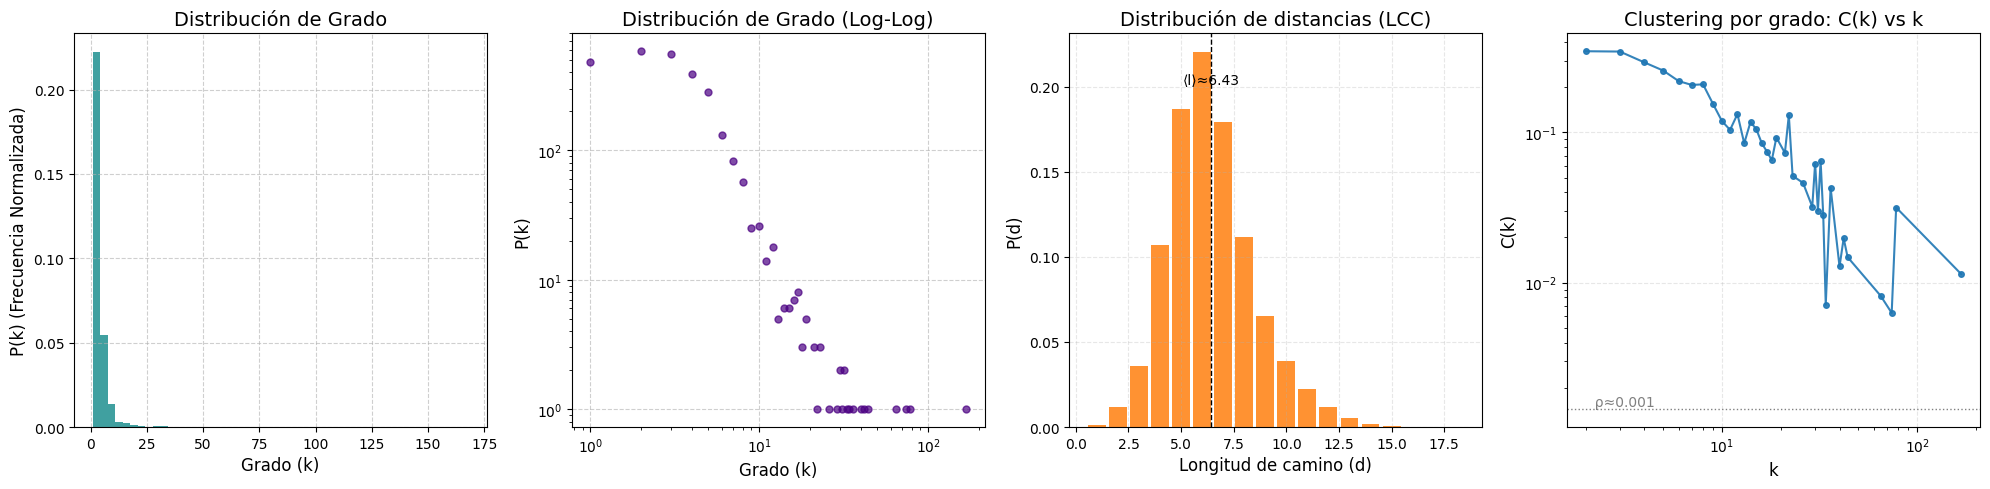

---

## Análisis  Red Eléctrica del Oeste de EE. UU.

### Dominio: Infraestructura / Energía

### Archivo:inf-power.mtx

### Nodos: 4941, Aristas: 6594

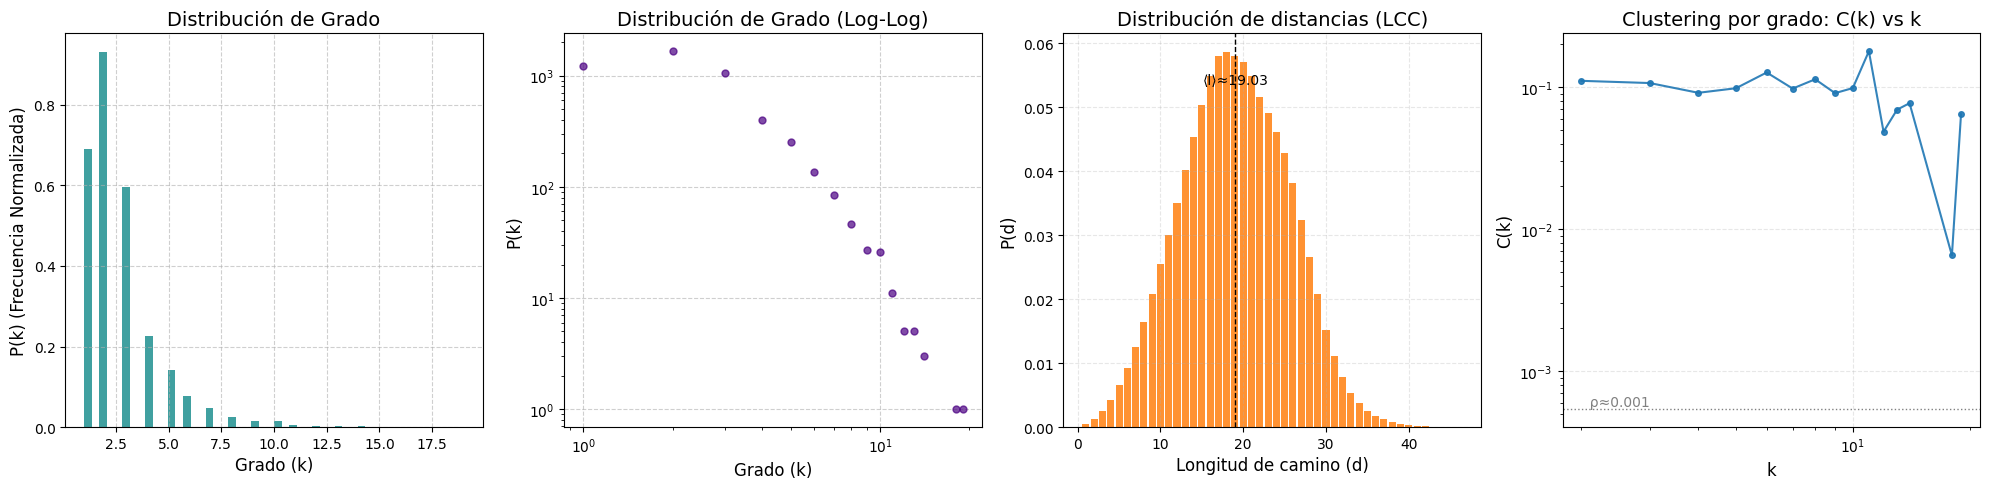

---

## Análisis  Red de Colaboración de Erdős

### Dominio: Ciencia / Colaboración

### Archivo:ca-Erdos992.mtx

### Nodos: 5094, Aristas: 7515

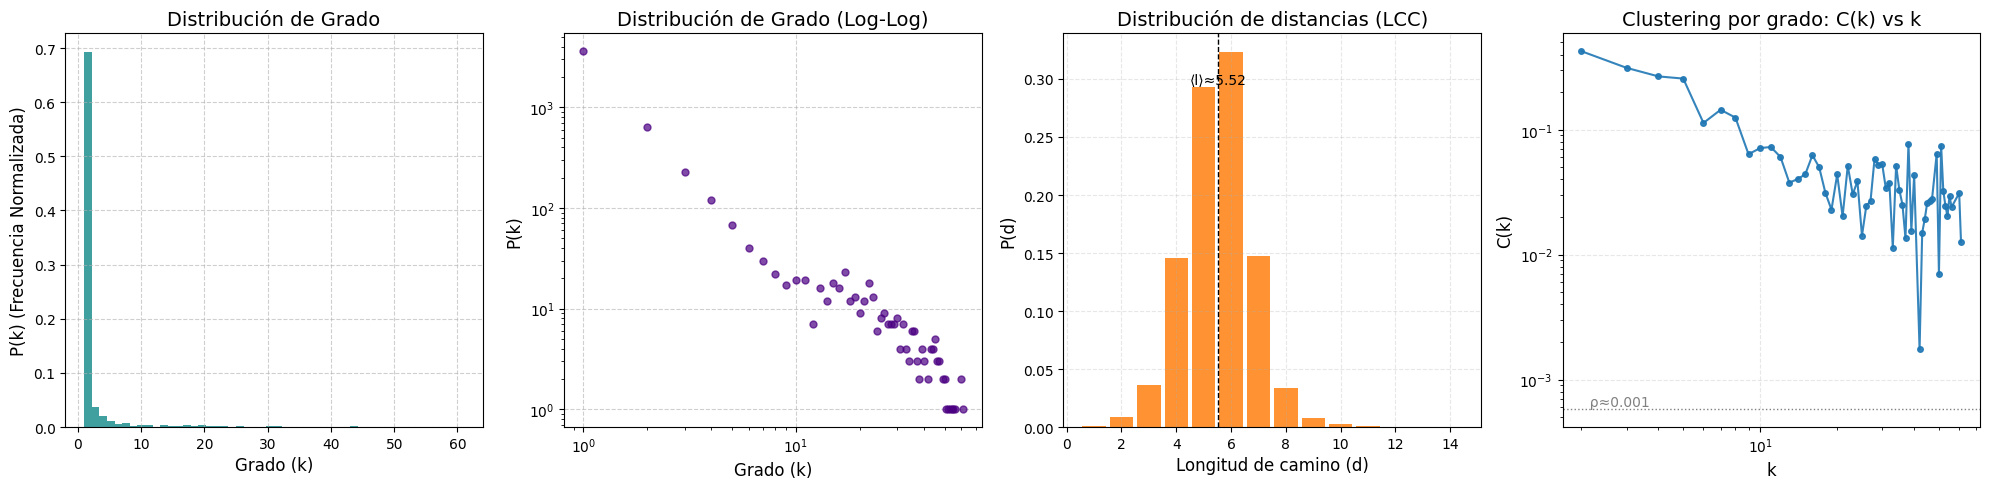

---

## Resumen de Métricas de Redes Individuales

| Grafo   | Dominio                   |   Nodos |   Aristas |   <k> (Grado Promedio) |   σk (Desv. Est. Grado) |   Densidad |   <l> (Camino Mín. Prom.) |   L (Clustering Promedio) |   Componentes Conexas |
|:--------|:--------------------------|--------:|----------:|-----------------------:|------------------------:|-----------:|--------------------------:|--------------------------:|----------------------:|
| G1      | Ciencia / Red de Citación |    2708 |      5278 |                   3.9  |                    5.23 |     0.0014 |                      6.31 |                    0.2407 |                    78 |
| G2      | Infraestructura / Energía |    4941 |      6594 |                   2.67 |                    1.79 |     0.0005 |                     18.99 |                    0.0801 |                     1 |
| G3      | Ciencia / Colaboración    |    5094 |      7515 |                   2.95 |                    6.28 |     0.0006 |                      5.51 |                    0.0

---

## Comparación de Redes

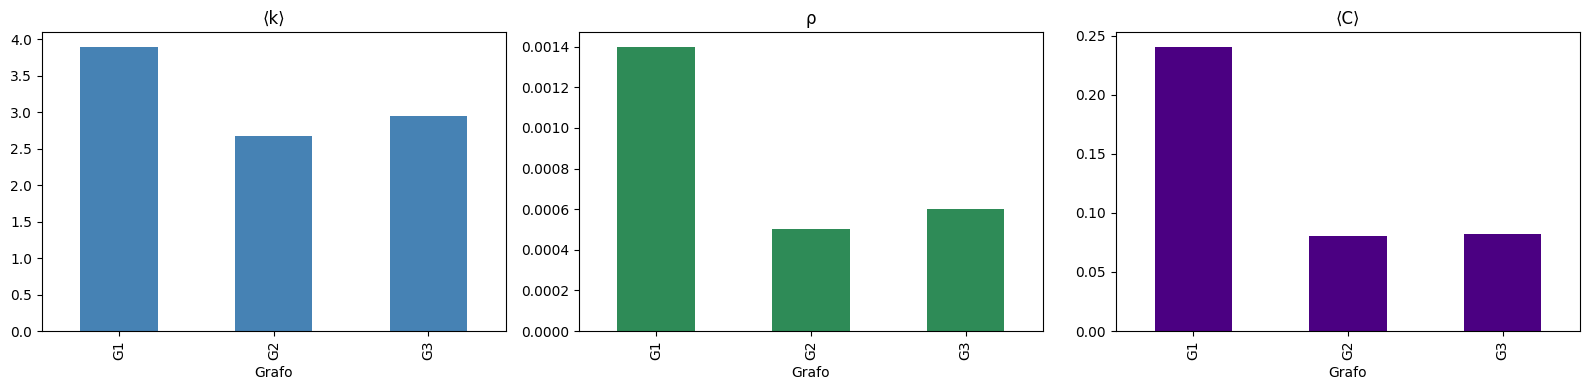

<IPython.core.display.Javascript object>

In [ ]:
# @title
import networkx as nx
from pathlib import Path
from scipy.io import mmread

from pathlib import Path
import re
import io
import networkx as nx

def load_graph_any(path, inner_name=None):
    """
    Carga un grafo desde:
      - .mtx / .mtx.gz : Matrix Market (matriz/coord) [robusto: si falla mmread, cae a edgelist]
      - .gml
      - .graphml
      - .edge / .edges / .txt : lista de aristas (u v [w]) con autodetección de separador
    Retorna nx.Graph (no dirigido, sin autoloops).
    """
    p = Path(path)
    suffs = ''.join(p.suffixes).lower()

    def _ensure_undirected_simple(G):
        G = nx.Graph(G)  # colapsa direcciones/multi
        G.remove_edges_from(nx.selfloop_edges(G))
        return G

    def _read_edgelist_text(text):
        """Lee edge list desde un string con heurísticas."""
        # quita BOM
        if text and text[0] == "\ufeff":
            text = text[1:]
        # líneas útiles
        lines = [ln for ln in text.splitlines() if ln.strip() != ""]
        # salta posible cabecera textual en la primera línea
        if lines and re.search(r"[A-Za-z]", lines[0]) and not re.search(r"\d+\s+\d+", lines[0]):
            lines = lines[1:]
        # líneas sin comentarios
        body = [ln for ln in lines if not ln.lstrip().startswith(("#", "%"))]

        # autodetecta separador: tab, coma, ;, espacios
        delim = None
        for d in ["\t", ",", ";", " "]:
            splitter = (r"\s+" if d == " " else re.escape(d))
            cols = [len([x for x in re.split(splitter, ln.strip()) if x != ""])
                    for ln in body[:50] if ln.strip()]
            if cols and all(c in (2,3) for c in cols):
                delim = (None if d == " " else d)
                break

        # orden de intentos: weighted/unweighted x nodetype int/str
        orders = [("weighted", int), ("weighted", str), ("unweighted", int), ("unweighted", str)]
        last_err = None
        for mode, nt in orders:
            try:
                it = (ln for ln in body)
                if mode == "weighted":
                    G = nx.read_weighted_edgelist(it, delimiter=delim, nodetype=nt)
                else:
                    G = nx.read_edgelist(it, delimiter=delim, nodetype=nt)
                return _ensure_undirected_simple(G)
            except Exception as e:
                last_err = e
                continue
        raise RuntimeError(f"No pude interpretar el edge list: {last_err}")

    # --- Matrix Market ---
    if suffs.endswith(('.mtx', '.mtx.gz')):
        try:
            from scipy.io import mmread
            A = mmread(str(p))
            try:
                A = A.tocsr()
            except Exception:
                A = A.tocoo()
            try:
                if (A != A.T).nnz != 0:
                    A = A + A.T
            except Exception:
                A = A + A.T
            if hasattr(A, "setdiag"):
                A.setdiag(0)
            try:
                A.eliminate_zeros()
            except Exception:
                pass
            G = nx.from_scipy_sparse_array(A)
            return _ensure_undirected_simple(G)
        except Exception:
            # Fallback: interpretarlo como edge list ignorando '%'
            with open(p, "r", encoding="utf-8", errors="replace") as fp:
                return _read_edgelist_text(fp.read())

    # --- GML ---
    if p.suffix.lower() == '.gml':
        return _ensure_undirected_simple(nx.read_gml(str(p)))

    # --- GraphML ---
    if p.suffix.lower() == '.graphml':
        return _ensure_undirected_simple(nx.read_graphml(str(p)))

    # --- Edge list (edges/edge/txt) ---
    if p.suffix.lower() in ('.edges', '.edge', '.txt'):
        with open(p, "r", encoding="utf-8", errors="replace") as fp:
            return _read_edgelist_text(fp.read())

    raise ValueError(f"Extensión no soportada para: {p.name}")


def analiza_red(graph_path, graph_name):
    from IPython.display import display, Markdown
    import numpy as np
    import networkx as nx
    import matplotlib.pyplot as plt

    # --- Cargar grafo ---
    try:
        G = load_graph_any(graph_path)  # graph_path puede ser str o Path
    except Exception as e:
        print(f"Error al cargar {graph_path}: {e}. Skipping this graph.")
        return None, None

    display(Markdown(f"### Nodos: {G.number_of_nodes()}, Aristas: {G.number_of_edges()}"))

    # --- Grados ---
    degrees = [d for _, d in G.degree()]

    # === FIGURA: 3 paneles (hist grados, log-log, distancias LCC) ===
    #fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=False)
    fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharex=False)
    # (1) Histograma de grados (densidad)
    axes[0].hist(degrees, bins=50, density=True, alpha=0.75, color='teal')
    axes[0].set_title('Distribución de Grado', fontsize=14)
    axes[0].set_xlabel('Grado (k)', fontsize=12)
    axes[0].set_ylabel('P(k) (Frecuencia Normalizada)', fontsize=12)
    axes[0].grid(True, linestyle='--', alpha=0.6)

    # (2) Distribución de grado (Log-Log)
    degree_counts = nx.degree_histogram(G)             # conteos absolutos por k
    counts_filtered = np.array(degree_counts)
    non_zero_indices = np.where(counts_filtered > 0)[0]
    if len(non_zero_indices) > 1:
        axes[1].loglog(non_zero_indices,
                       counts_filtered[non_zero_indices],
                       'o', markersize=5, alpha=0.7, color='indigo')
        axes[1].set_title('Distribución de Grado (Log-Log)', fontsize=14)
        axes[1].set_xlabel('Grado (k)', fontsize=12)
        axes[1].set_ylabel('P(k)', fontsize=12)
        axes[1].grid(True, linestyle='--', alpha=0.6)
    else:
        axes[1].set_title('Distribución de Grado (Log-Log)\n(no suficiente soporte)', fontsize=12)
        axes[1].axis('off')

    # (3) Distribución de distancias (en la LCC)
    try:
        num_connected_components = nx.number_connected_components(G)
    except nx.NetworkXNotImplemented:
        # Si fuese dirigido, puedes cambiar a weakly_connected_components
        num_connected_components = 0

    if num_connected_components > 0:
        components = list(nx.connected_components(G))
        largest_comp = max(components, key=len)
        largest_comp_graph = G.subgraph(largest_comp).copy()

        if largest_comp_graph.number_of_nodes() > 1:
            # Recolectar distancias con BFS desde varios orígenes (sampling para acelerar)
            nH = largest_comp_graph.number_of_nodes()
            # sampled sources: hasta 300 o todos si es chico
            rng = np.random.default_rng(42)
            sources = list(largest_comp_graph.nodes())
            if nH > 300:
                sources = rng.choice(sources, size=300, replace=False)

            dists = []
            for s in sources:
                sp = nx.single_source_shortest_path_length(largest_comp_graph, s)
                dists.extend([d for t, d in sp.items() if d > 0])  # excluir 0 (s->s)

            if len(dists) > 0:
                bins = np.arange(0.5, max(dists) + 1.5, 1)
                axes[2].hist(dists, bins=bins, rwidth=.85, alpha=0.85,
                             color='tab:orange', density=True)
                axes[2].set_xlabel('Longitud de camino (d)', fontsize=12)
                axes[2].set_ylabel('P(d)', fontsize=12)
                axes[2].set_title('Distribución de distancias (LCC)', fontsize=14)
                axes[2].grid(True, ls='--', alpha=.3)

                avg_d_sample = float(np.mean(dists))
                axes[2].axvline(avg_d_sample, color='k', ls='--', lw=1)
                axes[2].text(avg_d_sample, axes[2].get_ylim()[1]*0.9,
                             f'⟨l⟩≈{avg_d_sample:.2f}', ha='center', va='top')
            else:
                axes[2].set_title('Distribución de distancias (LCC)\n(sin caminos finitos)', fontsize=12)
                axes[2].axis('off')
        else:
            axes[2].set_title('Distribución de distancias (LCC)\n(LCC trivial)', fontsize=12)
            axes[2].axis('off')
    else:
        axes[2].set_title('Distribución de distancias (LCC)\n(grafo sin componentes)', fontsize=12)
        axes[2].axis('off')

    # (4) Clustering por grado: C(k) vs k
    try:
        C_local = nx.clustering(G)           # Ci por nodo
        deg_dict = dict(G.degree())

        from collections import defaultdict
        bucket = defaultdict(list)
        for u, k in deg_dict.items():
            if k >= 2:                       # evita divisiones triviales (k=0/1 ⇒ Ci=0)
                bucket[k].append(C_local[u])

        if bucket:
            ks = np.array(sorted(bucket))
            Ck = np.array([np.mean(bucket[k]) for k in ks])

            axes[3].plot(ks, Ck, 'o-', ms=4, alpha=0.9)
            axes[3].set_xscale('log')
            axes[3].set_yscale('log')
            axes[3].set_xlabel('k', fontsize=12)
            axes[3].set_ylabel('C(k)', fontsize=12)
            axes[3].set_title('Clustering por grado: C(k) vs k', fontsize=14)
            axes[3].grid(True, ls='--', alpha=.3)

            # Línea guía de C ≈ ρ (útil para comparar con ER)
            rho = nx.density(G)
            axes[3].axhline(rho, color='gray', ls=':', lw=1)
            axes[3].text(ks.min(), rho, f'  ρ≈{rho:.3f}', va='bottom', ha='left', color='gray')
        else:
            axes[3].set_title('C(k) vs k (sin soporte)', fontsize=12)
            axes[3].axis('off')
    except Exception as e:
        axes[3].set_title('C(k) vs k (error)', fontsize=12)
        axes[3].axis('off')


    plt.tight_layout()
    plt.show()

    # === Métricas ===
    avg_degree = np.mean(degrees) if len(degrees) else float('nan')
    std_degree = np.std(degrees) if len(degrees) else float('nan')
    density = nx.density(G)
    avg_clustering = nx.average_clustering(G) if G.number_of_nodes() > 1 else float('nan')

    avg_shortest_path = np.nan
    if num_connected_components > 0:
        if largest_comp_graph.number_of_nodes() > 1 and nx.is_connected(largest_comp_graph):
            avg_shortest_path = nx.average_shortest_path_length(largest_comp_graph)
        else:
            print(f"Advertencia: La componente más grande de {graph_name} no es conexa para LSP.")
    else:
        print(f"Advertencia: El grafo {graph_name} no tiene componentes.")

    metrics = {
        'Grafo': graph_name,
        'Dominio': 'N/A',  # lo completarás afuera
        'Nodos': G.number_of_nodes(),
        'Aristas': G.number_of_edges(),
        '<k> (Grado Promedio)': f'{avg_degree:.2f}',
        'σk (Desv. Est. Grado)': f'{std_degree:.2f}',
        'Densidad': f'{density:.4f}',
        '<l> (Camino Mín. Prom.)': f'{avg_shortest_path:.2f}',
        'L (Clustering Promedio)': f'{avg_clustering:.4f}',
        'Componentes Conexas': int(num_connected_components) if num_connected_components is not None else None
    }

    return G, metrics


all_metrics_df = pd.DataFrame()
graphs = {}

for id,dominio,nombre,url, archivo in source_graph:
    display(Markdown("---"))
    display(Markdown(f"## Análisis  {nombre}") )
    display(Markdown(f"### Dominio: {dominio}" ))
    display(Markdown(f"### Archivo:{archivo}"))
    G, metrics = analiza_red(archivo, id)
    if G is not None:
        graphs[nombre] = G
        metrics['Dominio'] = dominio
        all_metrics_df = pd.concat([all_metrics_df, pd.DataFrame([metrics])], ignore_index=True)
display(Markdown("---"))
display(Markdown(f"## Resumen de Métricas de Redes Individuales") )
print(all_metrics_df.to_markdown(index=False))
display(Markdown("---"))

display(Markdown(f"## Comparación de Redes") )

if not all_metrics_df.empty:
    df = all_metrics_df.copy()
    cols_num = ['Nodos', 'Aristas', 'Componentes Conexas',
                '<k> (Grado Promedio)', 'σk (Desv. Est. Grado)',
                'Densidad', '<l> (Camino Mín. Prom.)', 'L (Clustering Promedio)']
    for c in cols_num:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')

    fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharex=False)
    df.plot(x='Grafo', y='<k> (Grado Promedio)', kind='bar',
            ax=axes[0], color='steelblue', legend=False, title='⟨k⟩')
    df.plot(x='Grafo', y='Densidad', kind='bar',
            ax=axes[1], color='seagreen', legend=False, title='ρ')
    df.plot(x='Grafo', y='L (Clustering Promedio)', kind='bar',
            ax=axes[2], color='indigo', legend=False, title='⟨C⟩')
    plt.tight_layout()
    plt.show()
else:
    print("No hay datos para comparar/graficar.")
display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 1e7})'))

### 2.a.5 Análisis
#### **G1 — Red de Citación de Artículos Científicos - Cora**
  En el histograma de grados se aprecia una distribución muy asimétrica: la gran mayoría de nodos tiene pocos enlaces y aparece una cola con algunos artículos que concentran muchas conexiones. Esto se refleja en un grado promedio moderado (⟨k⟩≈3.9) junto con una dispersión alta (σₖ≈5.23), una densidad muy baja (ρ≈0.0014) y, a la vez, un clustering alto (⟨C⟩≈0.24).

  En la versión log–log de la distribución de grado la cola muestra curvatura y no un tramo recto amplio; por eso, aunque hay hubs claros, la evidencia no respalda una ley de potencias “pura”. Hay nodos muy conectados, pero su frecuencia decae más rápido que en un ley de potencia ideal.

  La distribución de distancias en la LCC presenta un pico bien definido alrededor de ⟨l⟩≈6.3, lo que sugiere un mundo pequeño: desde cualquier artículo típico bastan pocos saltos para llegar a otro, pese a la gran dispersión del grado.

  El gráfico C(k) vs k desciende de forma sistemática: los nodos de bajo grado se sitúan en vecindarios más densos, mientras que los hubs conectan módulos distintos y exhiben menor clustering local. Esa pendiente descendente es una marca de organización jerárquica: grupos densos unidos por pocos conectores de alto grado.

---
#### **G2 - Red Eléctrica del Oeste de EE. UU.**

  El histograma de grados es estrecho y centrado en valores pequeños (1–4). La red presenta ⟨k⟩≈2.67 y σₖ≈1.79, sin hubs prominentes, lo que es consistente con restricciones físicas y de costo en infraestructuras embebidas en el espacio.

  En el gráfico log–log, la distribución cae rápido y no muestra el tramo lineal propio de una cola de potencia, por lo que no hay evidencia de libre escala; el perfil es más cercano a uno casi-Poisson con dispersión acotada.

  La distribución de distancias es amplia y centrada en valores altos (⟨l⟩≈19), señalando caminos largos y accesibilidad global costosa en número de saltos, algo típico de topologías cercanas a redes planares con pocos atajos.

  El C(k) vs k es del orden de 0.1 —claramente por encima de la densidad (ρ≈0.0005)— pero sin tendencia jerárquica marcada. Esto sugiere cierre triádico local por proximidad física, sin que la organización dependa fuertemente del grado.

---
#### **G3 - Red de Colaboración de Erdős**

  En el histograma de grados se observa una distribución muy sesgada, con mayoría de autores de bajo grado y algunos muy prolíficos que actúan como hubs, junto con un clustering medio apreciable (⟨C⟩≈0.082), habitual en redes sociales de colaboración.

  El gráfico log–log desciende con suave curvatura y sin un tramo lineal amplio, lo que indica una cola pesada pero no un power-law puro; es coherente con mecanismos de truncamiento (p. ej., límites de productividad) o con un comportamiento lognormal.

  La distribución de distancias muestra un pico en valores bajos (⟨l⟩≈5.5), reflejando un marcado comportamiento de mundo pequeño: los hubs y autores puente acortan rutas y conectan comunidades, reduciendo la longitud típica.

  Por último, C(k) decrece con k, señal de jerarquía estructural: los autores con pocos colaboradores se agrupan en vecindarios densos, mientras que los muy conectados enlazan comunidades y, por ello, exhiben menor clustering local.

---
En resumen G1 y G3 presentan colas pesadas, organización jerárquica y propiedad small-world, pero no evidencia robusta de una ley de potencias pura; G2 no es de libre escala y responde al perfil de una red espacial, con grados bajos y caminos largos. Si se quisiera afirmar “scale-free” con rigor en G1/G3, convendría contrastar formalmente frente a alternativas (p. ej., tests de Clauset–Shalizi–Newman) y, en citación, considerar específicamente el in-degree en un grafo dirigido.



---


### 2.b Seleccione muchas redes del mismo dominio y realice los mismos experimentos de la parte (a), que observa?




#### 2.b.1 Redes del mismo dominio

Las redes complejas son una herramienta fundamental para modelar y comprender sistemas interconectados del mundo real. Entre las infraestructuras más críticas para el funcionamiento de la sociedad moderna se encuentran las redes de suministro eléctrico (Power Grids), cuya estabilidad y eficiencia son vitales. Estas redes representan la topología de cómo las centrales generadoras, las subestaciones y los transformadores se conectan entre sí a través de líneas de transmisión de alta tensión.


####2.b.2 Analisis y Descarga de Datasets

Primero se descargaran  los 7 dataset encontrados para redes de suministro electrico y luego se realizara la graficacion de metricas para cada uno, realizando al final una comparacion entre las metricas.

| URL (archivo)        | Nombre            |
|----------------------|----------------------------|
| power-494-bus.zip    | Power Grid – 494-bus       |
| power-662-bus.zip    | Power Grid – 662-bus       |
| power-685-bus.zip    | Power Grid – 685-bus       |
| power-1138-bus.zip   | Power Grid – 1138-bus      |
| power-eris1176.zip   | Power Grid – eris1176      |
| power-bcspwr09.zip   | Power Grid – bcspwr09      |
| power-bcspwr10.zip   | Power Grid – bcspwr10      |




---

## Análisis  Power Grid – 494-bus

### Dominio: Infraestructura / Red de Energía

### Archivo:power-494-bus.mtx

### Nodos: 494, Aristas: 586

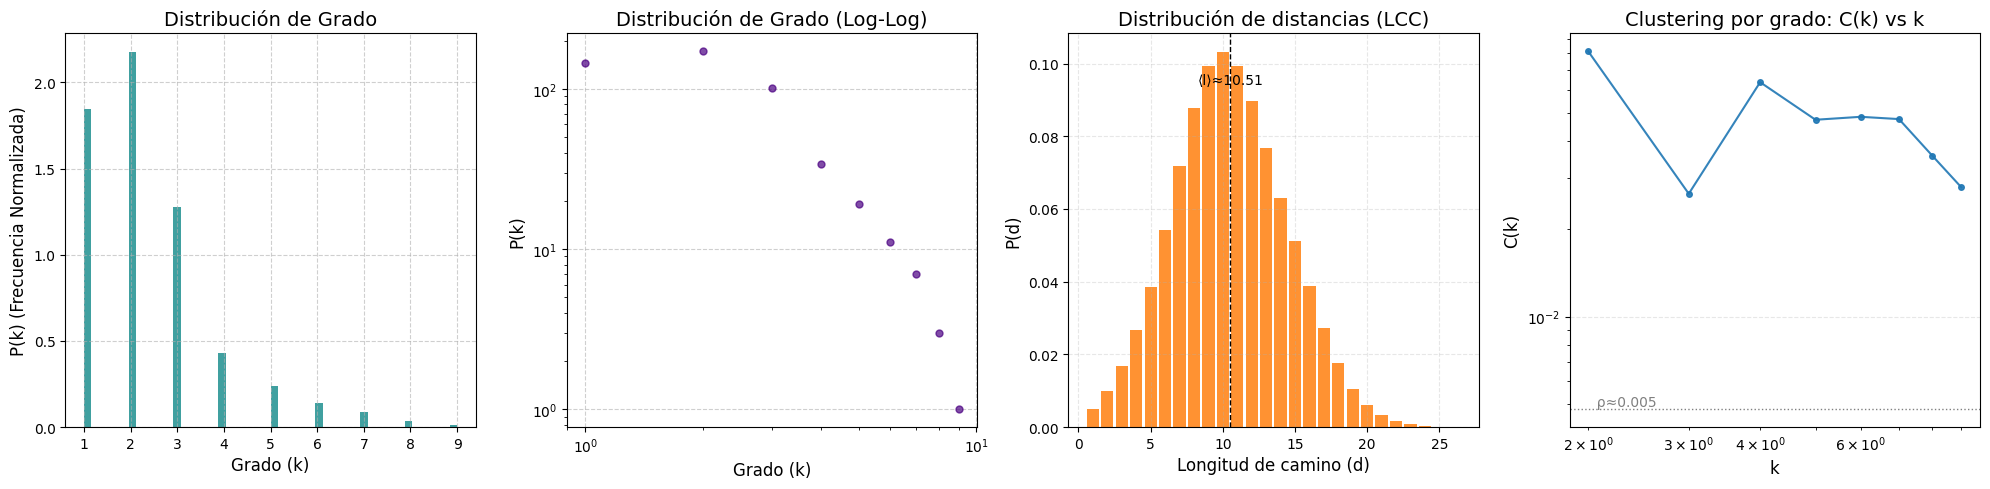

---

## Análisis  Power Grid – 662 bus

### Dominio: Infraestructura / Red de Energía

### Archivo:power-662-bus.mtx

### Nodos: 662, Aristas: 906

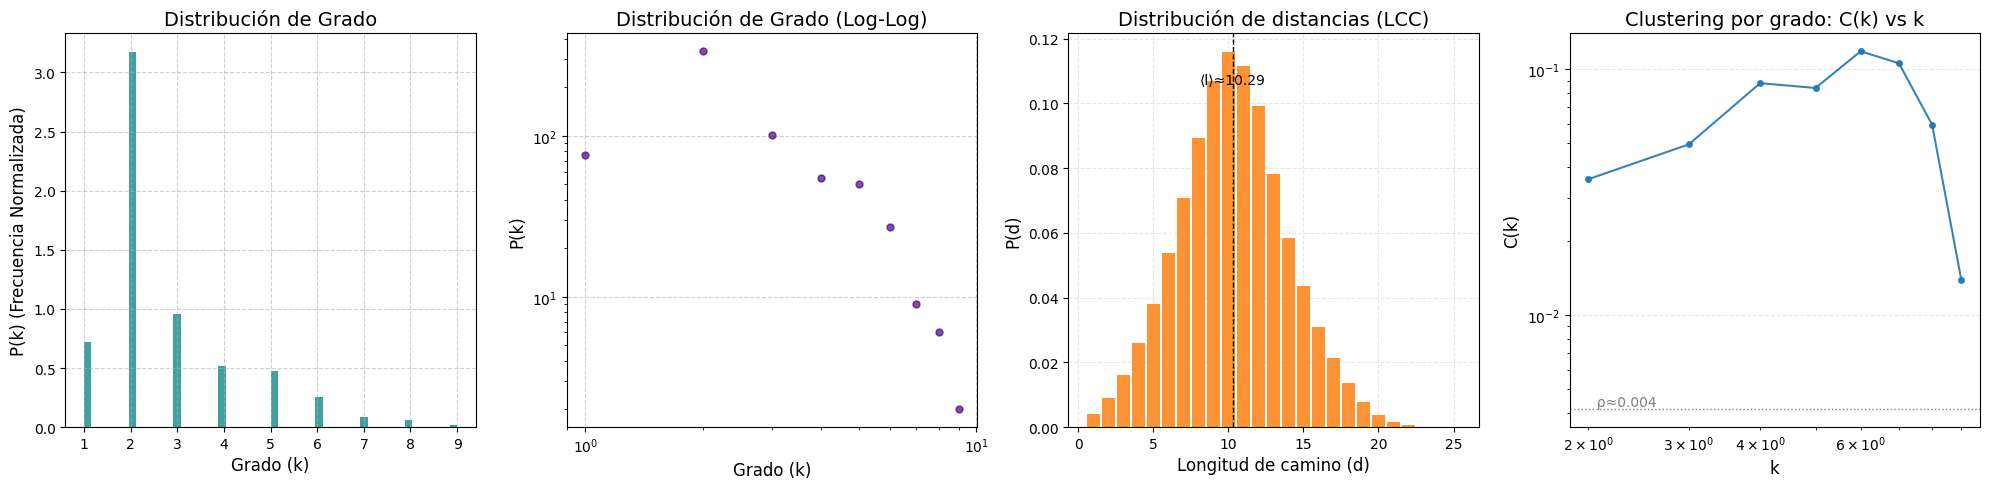

---

## Análisis  Power Grid – 685 bus

### Dominio: Infraestructura / Red de Energía

### Archivo:power-685-bus.mtx

### Nodos: 685, Aristas: 1282

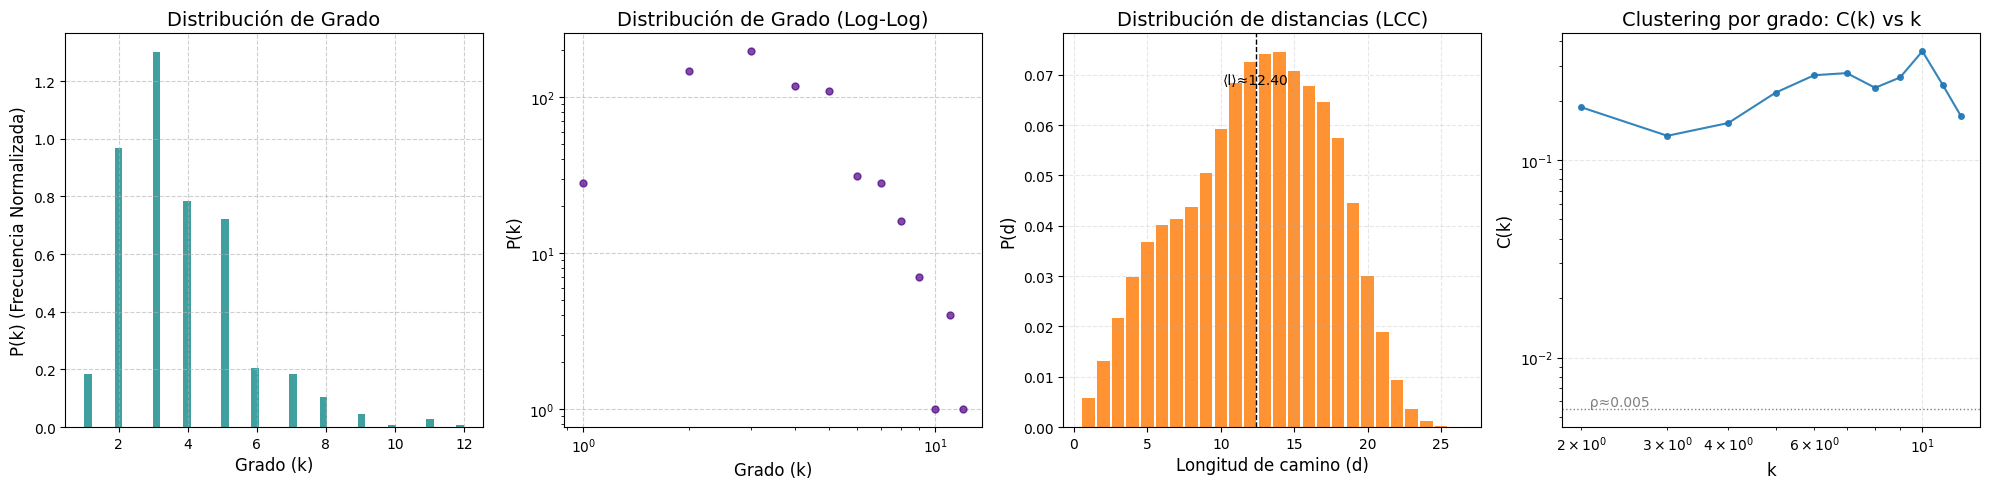

---

## Análisis  Power Grid – 1138 bus

### Dominio: Infraestructura / Red de Energía

### Archivo:power-1138-bus.mtx

### Nodos: 1138, Aristas: 1458

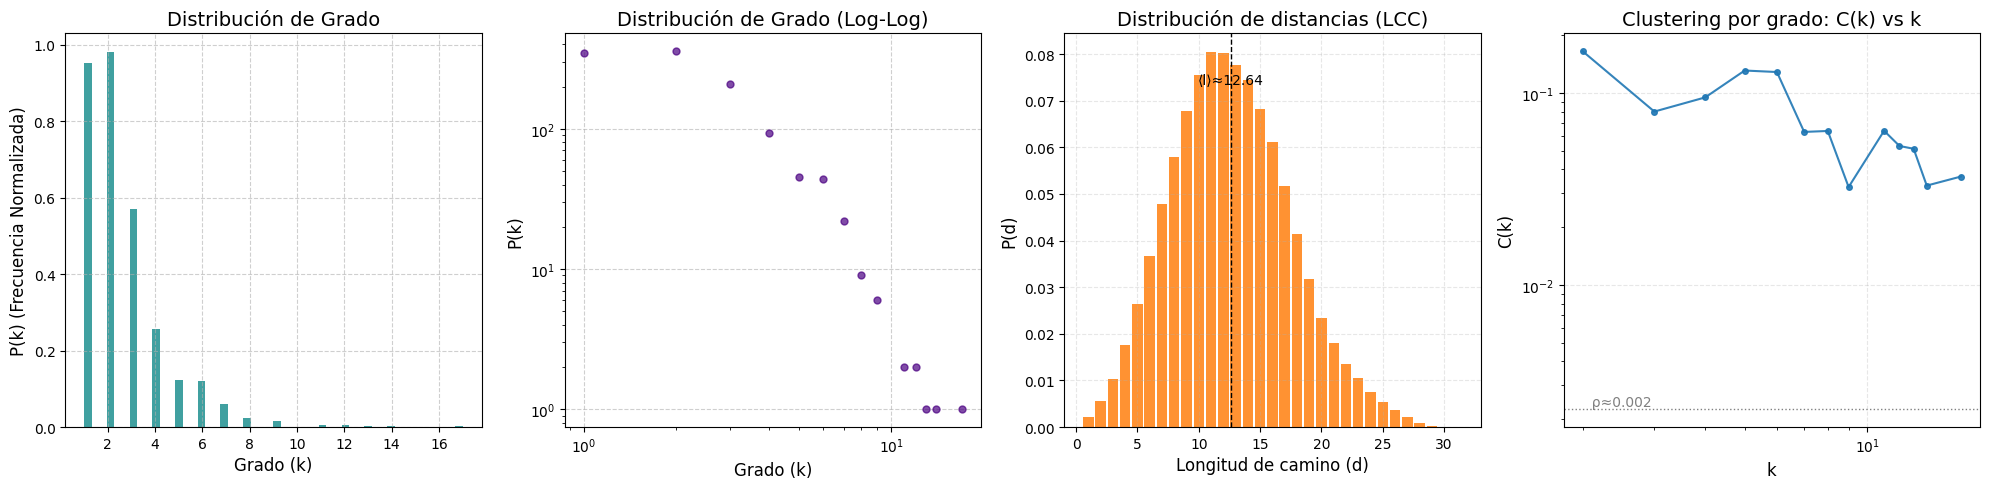

---

## Análisis  Power Grid – eris1176

### Dominio: Infraestructura / Red de Energía

### Archivo:power-eris1176.mtx

### Nodos: 1176, Aristas: 8688

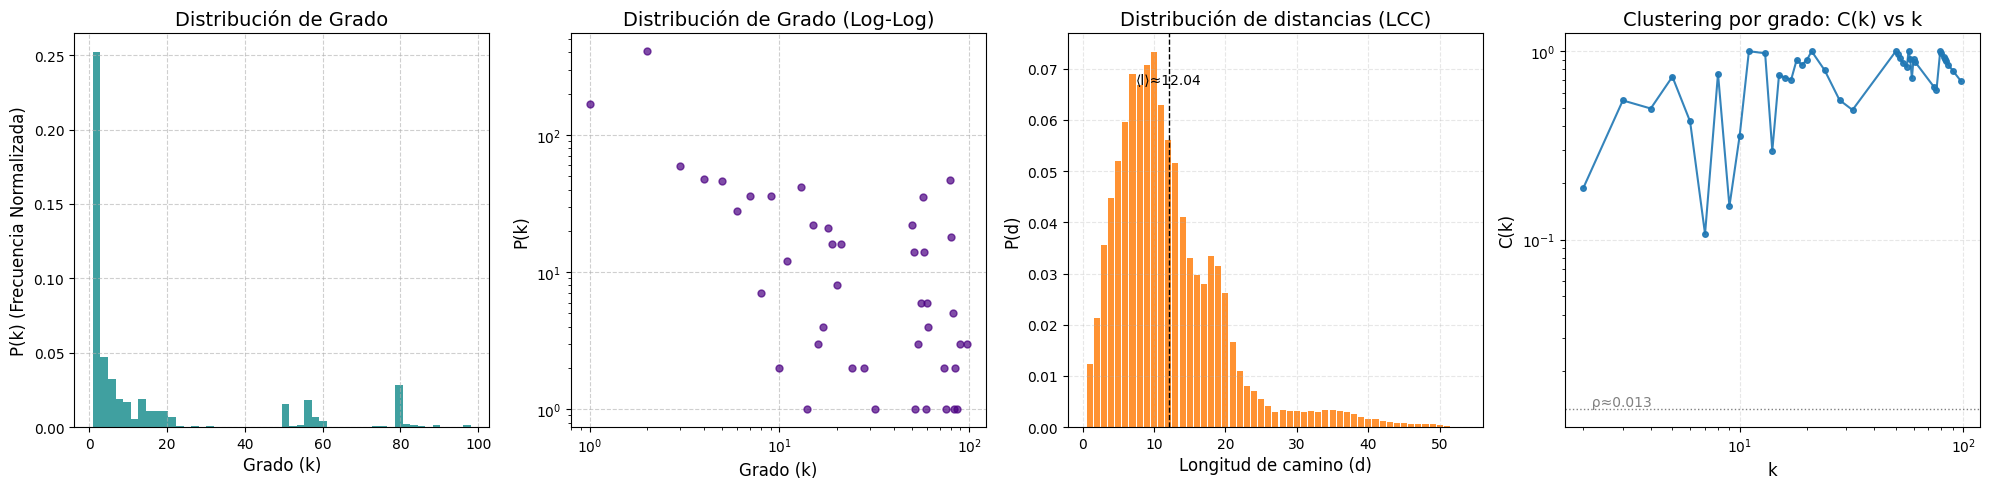

---

## Análisis  Power Grid – bcspwr09

### Dominio: Infraestructura / Red de Energía

### Archivo:power-bcspwr09.mtx

### Nodos: 1723, Aristas: 2394

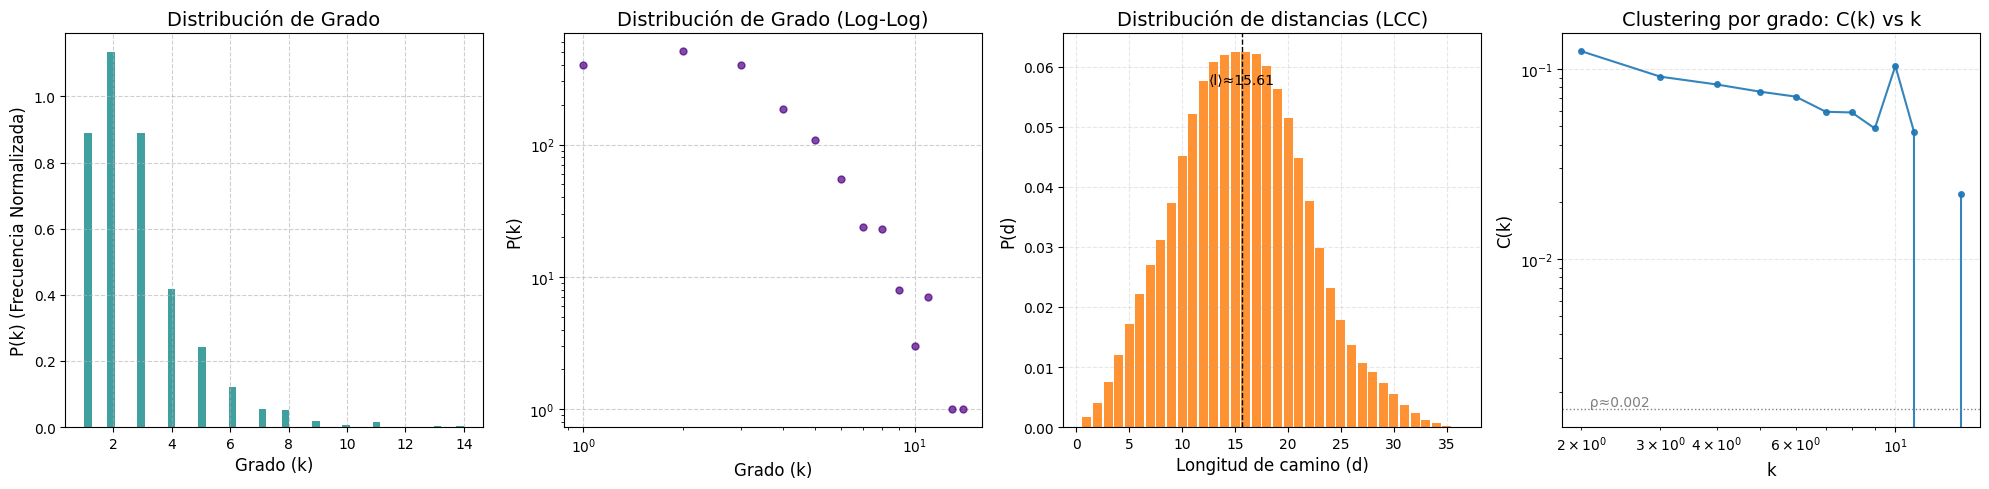

---

## Análisis  Power Grid – bcspwr10

### Dominio: Infraestructura / Red de Energía

### Archivo:power-bcspwr10.mtx

### Nodos: 5300, Aristas: 8271

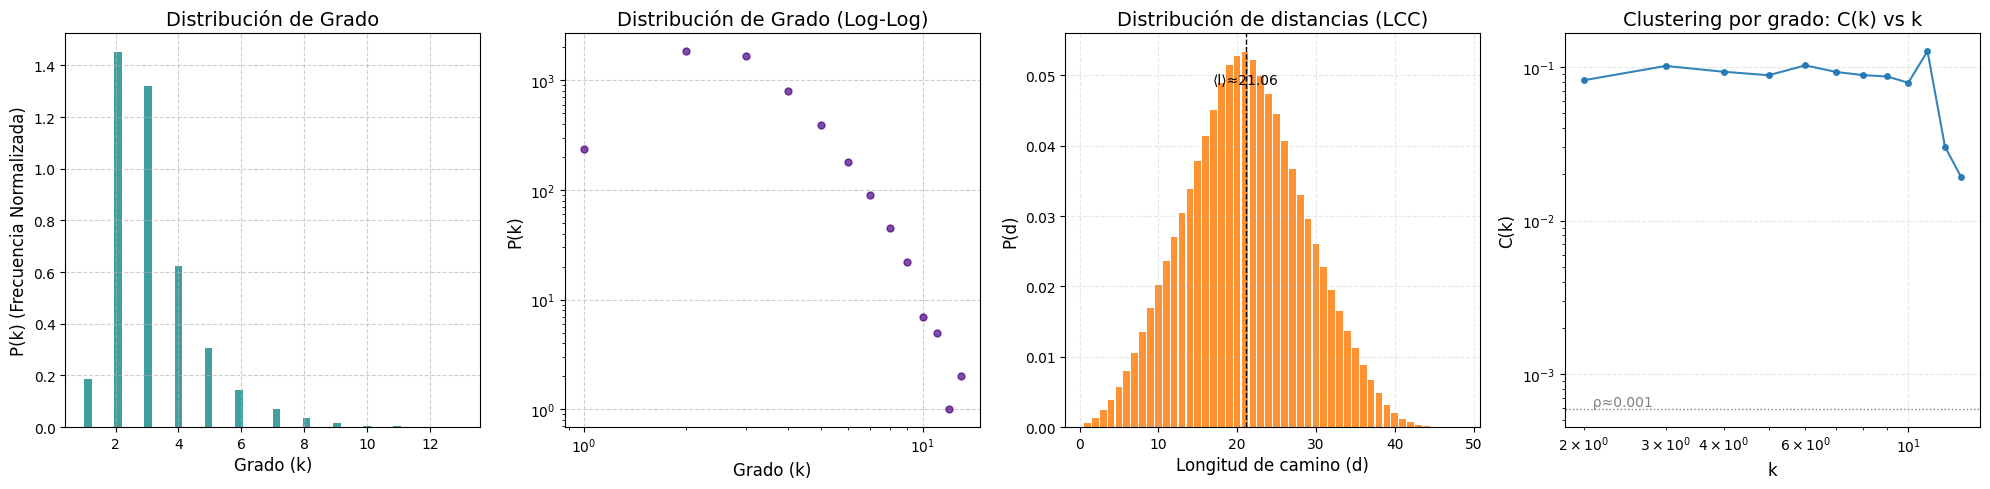

---

## Resumen de Métricas de Redes Individuales

| Grafo   | Dominio                          |   Nodos |   Aristas |   <k> (Grado Promedio) |   σk (Desv. Est. Grado) |   Densidad |   <l> (Camino Mín. Prom.) |   L (Clustering Promedio) |   Componentes Conexas |
|:--------|:---------------------------------|--------:|----------:|-----------------------:|------------------------:|-----------:|--------------------------:|--------------------------:|----------------------:|
| G1      | Infraestructura / Red de Energía |     494 |       586 |                   2.37 |                    1.42 |     0.0048 |                     10.47 |                    0.042  |                     1 |
| G2      | Infraestructura / Red de Energía |     662 |       906 |                   2.74 |                    1.48 |     0.0041 |                     10.24 |                    0.0462 |                     1 |
| G3      | Infraestructura / Red de Energía |     685 |      1282 |                   3.74 |                    1.79 |     0.0055 |                

---

## Comparación de Redes

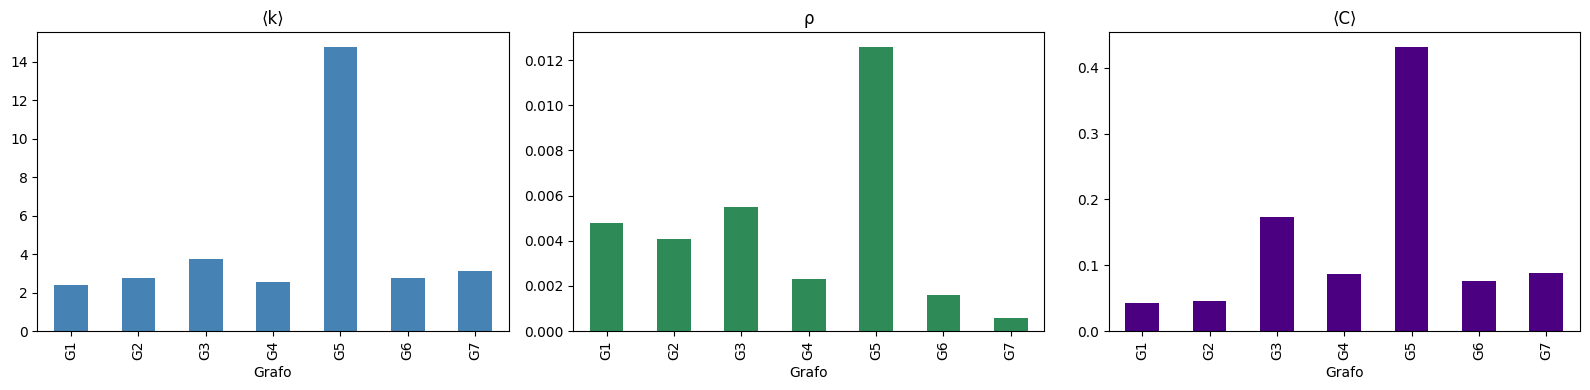

<IPython.core.display.Javascript object>

In [ ]:
# @title
source = [
    ("G1","Infraestructura / Red de Energía","Power Grid – 494-bus", "https://nrvis.com/download/data/power/power-494-bus.zip","power-494-bus.mtx"),
    ("G2","Infraestructura / Red de Energía","Power Grid – 662 bus", "https://nrvis.com/download/data/power/power-662-bus.zip","power-662-bus.mtx"),
    ("G3","Infraestructura / Red de Energía","Power Grid – 685 bus", "https://nrvis.com/download/data/power/power-685-bus.zip","power-685-bus.mtx"),
    ("G4","Infraestructura / Red de Energía","Power Grid – 1138 bus", "https://nrvis.com/download/data/power/power-1138-bus.zip","power-1138-bus.mtx"),
    ("G5","Infraestructura / Red de Energía","Power Grid – eris1176", "https://nrvis.com/download/data/power/power-eris1176.zip","power-eris1176.mtx"),
    ("G6","Infraestructura / Red de Energía","Power Grid – bcspwr09", "https://nrvis.com/download/data/power/power-bcspwr09.zip","power-bcspwr09.mtx"),
    ("G7","Infraestructura / Red de Energía","Power Grid – bcspwr10", "https://nrvis.com/download/data/power/power-bcspwr10.zip","power-bcspwr10.mtx"),
]

all_metrics_df = pd.DataFrame()
graphs = {}

for id,dominio,nombre,url, archivo in source:
    display(Markdown("---"))
    display(Markdown(f"## Análisis  {nombre}") )
    display(Markdown(f"### Dominio: {dominio}" ))
    display(Markdown(f"### Archivo:{archivo}"))
    G, metrics = analiza_red(archivo, id)
    if G is not None:
        graphs[nombre] = G
        metrics['Dominio'] = dominio
        all_metrics_df = pd.concat([all_metrics_df, pd.DataFrame([metrics])], ignore_index=True)
display(Markdown("---"))
display(Markdown(f"## Resumen de Métricas de Redes Individuales") )
print(all_metrics_df.to_markdown(index=False))
display(Markdown("---"))

display(Markdown(f"## Comparación de Redes") )

if not all_metrics_df.empty:
    df = all_metrics_df.copy()
    cols_num = ['Nodos', 'Aristas', 'Componentes Conexas',
                '<k> (Grado Promedio)', 'σk (Desv. Est. Grado)',
                'Densidad', '<l> (Camino Mín. Prom.)', 'L (Clustering Promedio)']
    for c in cols_num:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')

    fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharex=False)
    df.plot(x='Grafo', y='<k> (Grado Promedio)', kind='bar',
            ax=axes[0], color='steelblue', legend=False, title='⟨k⟩')
    df.plot(x='Grafo', y='Densidad', kind='bar',
            ax=axes[1], color='seagreen', legend=False, title='ρ')
    df.plot(x='Grafo', y='L (Clustering Promedio)', kind='bar',
            ax=axes[2], color='indigo', legend=False, title='⟨C⟩')
    plt.tight_layout()
    plt.show()
else:
    print("No hay datos para comparar/graficar.")
display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 1e7})'))

####

### 2.b.3 Análisis

En todas las redes eléctricas analizadas, la distribución de grado es angosta y está concentrada en k=2–4; no aparecen hubs extremos y el gráfico log–log no muestra un tramo recto amplio → no son de libre escala. Solo eris1176 se sale del patron: tiene ⟨k⟩ mucho mayor (~14.8) y una cola más larga, por lo que se ve más densa que el resto.

La distribución de distancias (LCC) es unimodal y centrada en valores altos (≈10–21 saltos): son redes de caminos largos. En general, a mayor ⟨k⟩ o densidad, menor ⟨l⟩ (p. ej., eris1176 y 662-bus tienen las distancias más cortas dentro del grupo).

El clustering promedio es moderado (≈0.04–0.10) y claramente mayor que la densidad (ρ≈0.0005–0.005), con C(k) casi plano → hay cierre triádico local pero sin jerarquía fuerte. De nuevo, eris1176 destaca por clustering muy alto (~0.43), consistente con su mayor densidad.

---

En conclusión las redes de energía comparten el patrón típico de infraestructuras espaciales: grados bajos y limitados, caminos relativamente largos y clustering local; no muestran evidencia de ser scale-free. Un caso más denso (eris1176) rompe parcialmente el patrón pero sigue sin comportarse como libre-escala.
